<a href="https://colab.research.google.com/github/Agrigori7/ML-on-CAPM/blob/main/20_02_CAPM_w_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Building Dataset (daily % units) ---
Using Fama–French Daily Factors (Mkt-RF, RF) as market / RF.
Data Ready: 2700 rows. Columns: ['nvda_px', 'excess_mkt', 'rf', 'nvda_ret', 'excess_nvda']

=== OLS Summary: CAPM (Full Sample) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1735      0.045      3.870      0.000       0.086       0.261
excess_mkt     1.7383      0.039     45.130      0.000       1.663       1.814

Diagnostics:
alpha     : 0.1735
beta      : 1.7383
alpha_t   : 3.8700
beta_t    : 45.1304
R2        : 0.4302
BP_p      : 0.9440
RESET_p   : 0.3035
JB_p      : 0.0000
DW        : 2.0850

--- Regime thresholds (FULL sample) ---
q25 = -0.400 pps | q75 = 0.603 pps

Regime counts:
Regime
Normal (Mid 50%)    1351
Bull (Top 25%)       675
Bear (Bot 25%)       674
Name: count, dtype: int64

   DESIGN A: IN-SAMPLE PERFORMANCE (OVERALL + BY REGIME)
Model 

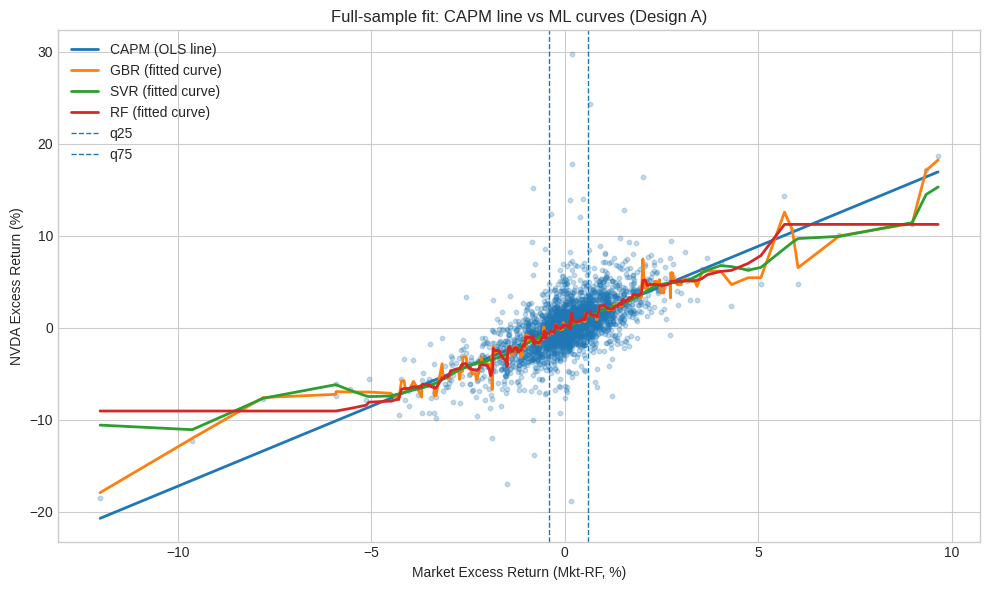

In [3]:
# ============================================================
# DESIGN A (STRUCTURAL / FULL SAMPLE):
# CAPM vs ML fit, and regime-conditional performance (25/50/25)
# NVDA 2015–2025
# ============================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader import data as pdr

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera, kruskal

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")
np.random.seed(42)

START = "2015-01-01"
END   = "2025-12-31"

# -------------------------
# 1) DATA
# -------------------------
def _flatten_yf(px: pd.DataFrame) -> pd.DataFrame:
    px = px.copy()
    if isinstance(px.columns, pd.MultiIndex):
        px.columns = [c[0] if isinstance(c, tuple) else c for c in px.columns]
    px.columns.name = None
    return px

def _yf_adj_close(ticker, start, end):
    df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    df = _flatten_yf(df)
    for col in ["Adj Close", "Close", ticker]:
        if col in df.columns:
            return df[[col]].rename(columns={col: ticker})
    raise ValueError(f"Could not find price column for {ticker}.")

def build_dataset():
    print("--- Building Dataset (daily % units) ---")

    nvda = _yf_adj_close("NVDA", START, END).rename(columns={"NVDA": "nvda_px"})

    ff_raw = pdr.DataReader(
        "F-F_Research_Data_Factors_daily",
        "famafrench",
        start=START,
        end=END
    )[0]

    # already in percent
    ff = ff_raw[["Mkt-RF", "RF"]].rename(columns={"Mkt-RF": "excess_mkt", "RF": "rf"})
    print("Using Fama–French Daily Factors (Mkt-RF, RF) as market / RF.")

    df = nvda.join(ff, how="inner").dropna()
    df["nvda_ret"] = df["nvda_px"].pct_change() * 100.0
    df["excess_nvda"] = df["nvda_ret"] - df["rf"]
    df = df.dropna()

    print(f"Data Ready: {df.shape[0]} rows. Columns: {list(df.columns)}")
    return df

df = build_dataset()

# -------------------------
# 2) CAPM OLS + diagnostics
# -------------------------
def run_ols_diagnostics(df_subset, label="Full Sample"):
    X = sm.add_constant(df_subset["excess_mkt"])
    y = df_subset["excess_nvda"]
    ols = sm.OLS(y, X).fit()

    resid = ols.resid
    bp_lm, bp_pvalue, _, _ = het_breuschpagan(resid, ols.model.exog)
    reset_res = linear_reset(ols, power=2, use_f=True)
    jb_stat, jb_pvalue = jarque_bera(resid)
    dw_stat = durbin_watson(resid)

    diagnostics = {
        "alpha": float(ols.params["const"]),
        "beta": float(ols.params["excess_mkt"]),
        "alpha_t": float(ols.tvalues["const"]),
        "beta_t": float(ols.tvalues["excess_mkt"]),
        "R2": float(ols.rsquared),
        "BP_p": float(bp_pvalue),
        "RESET_p": float(reset_res.pvalue),
        "JB_p": float(jb_pvalue),
        "DW": float(dw_stat)
    }

    print(f"\n=== OLS Summary: {label} ===")
    print(ols.summary().tables[1])

    print("\nDiagnostics:")
    for k, v in diagnostics.items():
        print(f"{k:10s}: {v:.4f}")

    return ols, diagnostics

full_ols, full_diag = run_ols_diagnostics(df, "CAPM (Full Sample)")

# -------------------------
# 3) ML models fit on FULL sample (Design A)
# -------------------------
def fit_models_full_sample(df_all):
    X = df_all[["excess_mkt"]].values
    y = df_all["excess_nvda"].values

    models = {}

    # OLS via sklearn (same functional form as CAPM)
    ols = LinearRegression().fit(X, y)
    models["OLS"] = ols

    # RF
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=5,
        min_samples_leaf=5,
        random_state=42
    ).fit(X, y)
    models["RF"] = rf

    # SVR (scaled)
    svr = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVR(kernel="rbf", C=10, gamma="scale"))
    ]).fit(X, y)
    models["SVR"] = svr

    # GBR (robust loss)
    gbr = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=2,
        loss="huber",
        random_state=42
    ).fit(X, y)
    models["GBR"] = gbr

    return models

models = fit_models_full_sample(df)

# -------------------------
# 4) Regimes: FULL-SAMPLE quantiles (25/50/25)
# -------------------------
q25 = df["excess_mkt"].quantile(0.25)
q75 = df["excess_mkt"].quantile(0.75)

def assign_regime(x):
    if x < q25:
        return "Bear (Bot 25%)"
    elif x > q75:
        return "Bull (Top 25%)"
    else:
        return "Normal (Mid 50%)"

df_eval = df.copy()
df_eval["Regime"] = df_eval["excess_mkt"].apply(assign_regime)

print("\n--- Regime thresholds (FULL sample) ---")
print(f"q25 = {q25:.3f} pps | q75 = {q75:.3f} pps")
print("\nRegime counts:")
print(df_eval["Regime"].value_counts())

# -------------------------
# 5) In-sample fit + regime-conditional performance
# -------------------------
def metrics_block(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = []
abs_errors = {}  # (model, regime) -> abs error array

X_all = df_eval[["excess_mkt"]].values
y_all = df_eval["excess_nvda"].values

# global predictions on the SAME observations
preds_all = {name: mdl.predict(X_all) for name, mdl in models.items()}

# overall metrics
for name, y_hat in preds_all.items():
    m = metrics_block(y_all, y_hat)
    results.append({"Sample": "Full Sample (in-sample)", "Model": name, **m})

# regime metrics + store abs errors
for regime, g in df_eval.groupby("Regime"):
    Xg = g[["excess_mkt"]].values
    yg = g["excess_nvda"].values
    for name, mdl in models.items():
        y_hat_g = mdl.predict(Xg)
        m = metrics_block(yg, y_hat_g)
        results.append({"Sample": f"{regime} (in-sample)", "Model": name, **m})
        abs_errors[(name, regime)] = np.abs(yg - y_hat_g)

results_df = pd.DataFrame(results)

print("\n===================================================")
print("   DESIGN A: IN-SAMPLE PERFORMANCE (OVERALL + BY REGIME)")
print("===================================================")
print(results_df.pivot(index="Sample", columns="Model", values="R2"))

# -------------------------
# 6) Kruskal–Wallis: do |errors| differ across regimes?
# -------------------------
regime_order = ["Bear (Bot 25%)", "Normal (Mid 50%)", "Bull (Top 25%)"]
model_list = ["OLS", "RF", "SVR", "GBR"]

print("\n=== Kruskal–Wallis tests on |errors| across regimes (in-sample) ===")
for m in model_list:
    samples = [abs_errors[(m, r)] for r in regime_order]
    H, p = kruskal(*samples)
    print(f"Model: {m:3s}  H = {H:.3f}, p = {p:.4f}")

# -------------------------
# 7) Wald test: beta equality across regimes (CAPM slope shifts)
# -------------------------
print("\n=== Wald Tests: Are CAPM betas different across regimes? (Full sample) ===")

df_test = df_eval.copy()
df_test["Bear"] = (df_test["Regime"] == "Bear (Bot 25%)").astype(int)
df_test["Bull"] = (df_test["Regime"] == "Bull (Top 25%)").astype(int)

df_test["MKT_Bear"] = df_test["excess_mkt"] * df_test["Bear"]
df_test["MKT_Bull"] = df_test["excess_mkt"] * df_test["Bull"]

X_rb = sm.add_constant(df_test[["excess_mkt", "MKT_Bear", "MKT_Bull"]])
y_rb = df_test["excess_nvda"]

regime_beta_model = sm.OLS(y_rb, X_rb).fit(cov_type="HC3")
print(regime_beta_model.summary().tables[1])

bear_vs_norm = regime_beta_model.t_test("MKT_Bear = 0")
bull_vs_norm = regime_beta_model.t_test("MKT_Bull = 0")
bear_vs_bull = regime_beta_model.t_test("MKT_Bear - MKT_Bull = 0")

print("\n--- Beta Equality Tests (Wald, Full Sample) ---")
print(f"Bear vs Normal : t={float(bear_vs_norm.tvalue):.3f}, p={float(bear_vs_norm.pvalue):.4f}")
print(f"Bull vs Normal : t={float(bull_vs_norm.tvalue):.3f}, p={float(bull_vs_norm.pvalue):.4f}")
print(f"Bear vs Bull   : t={float(bear_vs_bull.tvalue):.3f}, p={float(bear_vs_bull.pvalue):.4f}")

# -------------------------
# 8) Visual proof: fitted curves vs CAPM line
# -------------------------
# Sort by market excess return for a clean curve plot
plot_df = df_eval[["excess_mkt", "excess_nvda"]].copy().sort_values("excess_mkt")
x_sorted = plot_df["excess_mkt"].values.reshape(-1, 1)
y_sorted = plot_df["excess_nvda"].values

plt.figure(figsize=(10, 6))
plt.scatter(plot_df["excess_mkt"], plot_df["excess_nvda"], alpha=0.25, s=10)

# CAPM line (statsmodels)
capm_line = full_ols.predict(sm.add_constant(plot_df["excess_mkt"]))
plt.plot(plot_df["excess_mkt"], capm_line, linewidth=2, label="CAPM (OLS line)")

# ML fitted curves
for name in ["GBR", "SVR", "RF"]:
    y_hat = models[name].predict(x_sorted)
    plt.plot(x_sorted, y_hat, linewidth=2, label=f"{name} (fitted curve)")

plt.axvline(q25, linestyle="--", linewidth=1, label="q25")
plt.axvline(q75, linestyle="--", linewidth=1, label="q75")
plt.title("Full-sample fit: CAPM line vs ML curves (Design A)")
plt.xlabel("Market Excess Return (Mkt-RF, %)")
plt.ylabel("NVDA Excess Return (%)")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# ============================================================
# Diebold–Mariano Test: OLS vs GBR (Squared Error)
# ============================================================

import numpy as np
import statsmodels.api as sm
from scipy import stats

def diebold_mariano_test(y_true, yhat_model1, yhat_model2, maxlags=None):
    """
    DM test using squared-error loss.
    H0: E[d_t] = 0
    where d_t = e1^2 - e2^2

    model1 = baseline (e.g. OLS)
    model2 = challenger (e.g. GBR)

    Positive mean_d -> model2 better than model1
    """

    e1 = y_true - yhat_model1
    e2 = y_true - yhat_model2

    d = e1**2 - e2**2   # loss differential

    d = d[~np.isnan(d)]
    n = len(d)

    if n < 30:
        print("Too few observations for reliable DM test.")
        return None

    # Automatic lag selection (Newey-West)
    if maxlags is None:
        maxlags = int(np.floor(4 * (n / 100.0) ** (2 / 9)))
        maxlags = max(1, maxlags)

    # Regress d_t on constant with HAC variance
    X = np.ones((n, 1))
    model = sm.OLS(d, X).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})

    mean_d = model.params[0]
    se_mean = model.bse[0]
    dm_stat = mean_d / se_mean

    # One-sided test (GBR better than OLS)
    p_value = 1 - stats.norm.cdf(dm_stat)

    return {
        "mean_d": float(mean_d),
        "dm_stat": float(dm_stat),
        "p_value": float(p_value),
        "n_obs": n,
        "lags_used": maxlags
    }

In [7]:
# Select Bear regime (Design A example)
bear_df = df_eval[df_eval["Regime"] == "Bear (Bot 25%)"]

X_bear = bear_df[["excess_mkt"]].values
y_bear = bear_df["excess_nvda"].values

yhat_ols = models["OLS"].predict(X_bear)
yhat_gbr = models["GBR"].predict(X_bear)

dm_result = diebold_mariano_test(
    y_true=y_bear,
    yhat_model1=yhat_ols,   # baseline
    yhat_model2=yhat_gbr    # challenger
)

print("\n=== Diebold–Mariano: OLS vs GBR (Bear Regime) ===")
for k, v in dm_result.items():
    print(f"{k}: {v}")


=== Diebold–Mariano: OLS vs GBR (Bear Regime) ===
mean_d: 1.0095464816841995
dm_stat: 5.948687911939031
p_value: 1.3515022434518187e-09
n_obs: 674
lags_used: 6


In [8]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def dm_test(loss1, loss2, h=1, lags=None):
    """
    Diebold–Mariano test with HAC (Newey–West) variance.
    loss1, loss2: arrays of losses (e.g., squared error) for model 1 and 2
    Tests H0: E[d]=0 where d = loss1 - loss2
    """
    d = np.asarray(loss1) - np.asarray(loss2)
    d = d[~np.isnan(d)]
    n = len(d)
    if n < 30:
        return {"mean_d": np.nan, "dm_stat": np.nan, "p_value": np.nan, "n_obs": n, "lags_used": 0}

    # default lag choice (common): floor(n^(1/3))
    if lags is None:
        lags = int(np.floor(n ** (1/3)))

    d_mean = d.mean()

    # HAC variance of mean(d)
    # gamma_k = cov(d_t, d_{t-k})
    gamma0 = np.mean((d - d_mean) * (d - d_mean))
    hac = gamma0

    for k in range(1, lags + 1):
        cov_k = np.mean((d[k:] - d_mean) * (d[:-k] - d_mean))
        weight = 1.0 - k / (lags + 1.0)  # Bartlett
        hac += 2.0 * weight * cov_k

    var_dbar = hac / n
    dm_stat = d_mean / np.sqrt(var_dbar)

    # two-sided p-value
    p_value = 2.0 * (1.0 - norm.cdf(np.abs(dm_stat)))

    return {"mean_d": d_mean, "dm_stat": dm_stat, "p_value": p_value, "n_obs": n, "lags_used": lags}


def dm_by_regime(df, y_col, pred_ols, pred_gbr, regime_col="Regime", regimes=("Bear","Normal","Bull"), lags=None):
    out = []
    y = df[y_col].values

    for r in regimes:
        mask = (df[regime_col].values == r)
        y_r = y[mask]
        ols_r = np.asarray(pred_ols)[mask]
        gbr_r = np.asarray(pred_gbr)[mask]

        # squared error losses
        loss_ols = (y_r - ols_r) ** 2
        loss_gbr = (y_r - gbr_r) ** 2

        res = dm_test(loss_ols, loss_gbr, lags=lags)
        res["Regime"] = r
        # interpretation shortcut
        if np.isfinite(res["mean_d"]):
            if res["p_value"] < 0.05 and res["mean_d"] > 0:
                res["Conclusion"] = "GBR better (lower MSE)"
            elif res["p_value"] < 0.05 and res["mean_d"] < 0:
                res["Conclusion"] = "OLS better (lower MSE)"
            else:
                res["Conclusion"] = "No significant difference"
        else:
            res["Conclusion"] = "Too few obs"
        out.append(res)

    return pd.DataFrame(out)[["Regime","n_obs","lags_used","mean_d","dm_stat","p_value","Conclusion"]]


# ---- Example usage ----
# df must have df["Regime"] already (Bear/Normal/Bull)
# pred_ols_full and pred_gbr_full must be aligned to df rows (same length, same order)
# e.g., from Design A in-sample fit:
# pred_ols_full = models["OLS"].predict(X_full)
# pred_gbr_full = models["GBR"].predict(X_full)

dm_table = dm_by_regime(
    df=df,
    y_col="excess_nvda",
    pred_ols=pred_ols_full,
    pred_gbr=pred_gbr_full,
    regime_col="Regime",
    regimes=("Bear","Normal","Bull"),
    lags=None  # or set fixed lags like 6 for comparability
)

print(dm_table)

NameError: name 'pred_ols_full' is not defined

In [1]:
pip install yfinance pandas-datareader statsmodels scikit-learn


In [2]:
# ============================================================
# CAPM vs ML (Design A): Train on FULL sample, evaluate by regimes
# NVDA 2015–2025 | Full-sample fit + regime-wise error comparison
# Includes: CAPM diagnostics, ML fits, regime metrics, Kruskal-Wallis,
#           Wald beta-equality test, and Diebold–Mariano tests (OLS vs GBR)
# ============================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader import data as pdr

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera, kruskal, t as student_t

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# ------------------------------------------------------------
# Global Config
# ------------------------------------------------------------
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
np.random.seed(42)

START = "2010-01-01"
END   = "2025-12-31"

# ============================================================
# 1) DATA INGESTION & PREPROCESSING (daily % units)
# ============================================================

def _flatten_yf(px: pd.DataFrame) -> pd.DataFrame:
    px = px.copy()
    if isinstance(px.columns, pd.MultiIndex):
        px.columns = [c[0] if isinstance(c, tuple) else c for c in px.columns]
    px.columns.name = None
    return px

def _yf_adj_close(ticker: str, start: str, end: str) -> pd.DataFrame:
    try:
        df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        df = _flatten_yf(df)
        for col in ["Adj Close", "Close", ticker]:
            if col in df.columns:
                return df[[col]].rename(columns={col: ticker})
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
    return pd.DataFrame()

def build_dataset() -> pd.DataFrame:
    """
    NVDA prices from yfinance. Market + RF from Fama–French daily factors (preferred).
    Units:
      - Fama-French Mkt-RF and RF are already in daily percent.
      - NVDA returns computed as daily percent and excess_nvda = nvda_ret - rf.
    """
    print("--- Building Dataset (daily % units) ---")

    nvda = _yf_adj_close("NVDA", START, END).rename(columns={"NVDA": "nvda_px"})

    try:
        ff_raw = pdr.DataReader(
            "F-F_Research_Data_Factors_daily",
            "famafrench",
            start=START,
            end=END
        )[0]
        ff = ff_raw[["Mkt-RF", "RF"]].rename(columns={"Mkt-RF": "excess_mkt", "RF": "rf"})
        print("Using Fama–French Daily Factors (Mkt-RF, RF) as market / RF.")
    except Exception as e:
        raise RuntimeError(
            f"Fama–French download failed ({e}). "
            "For this script, please ensure famafrench source works."
        )

    df = nvda.join(ff, how="inner").dropna()
    df["nvda_ret"] = df["nvda_px"].pct_change() * 100.0
    df["excess_nvda"] = df["nvda_ret"] - df["rf"]
    df = df.dropna()

    print(f"Data Ready: {df.shape[0]} rows. Columns: {list(df.columns)}")
    return df

df = build_dataset()

# ============================================================
# 2) CAPM (Full sample) + Diagnostics
# ============================================================

def run_capm_diagnostics(df_subset: pd.DataFrame, label: str = "Sample"):
    X = sm.add_constant(df_subset["excess_mkt"])
    y = df_subset["excess_nvda"]

    ols = sm.OLS(y, X).fit()

    resid = ols.resid
    bp_lm, bp_pvalue, _, _ = het_breuschpagan(resid, ols.model.exog)
    reset_res = linear_reset(ols, power=2, use_f=True)
    jb_stat, jb_pvalue = jarque_bera(resid)
    dw_stat = durbin_watson(resid)

    diagnostics = {
        "label": label,
        "alpha": float(ols.params["const"]),
        "beta": float(ols.params["excess_mkt"]),
        "alpha_t": float(ols.tvalues["const"]),
        "beta_t": float(ols.tvalues["excess_mkt"]),
        "R2": float(ols.rsquared),
        "BP_p": float(bp_pvalue),
        "RESET_p": float(reset_res.pvalue),
        "JB_p": float(jb_pvalue),
        "DW": float(dw_stat),
    }

    print(f"\n=== OLS Summary: {label} ===")
    print(ols.summary().tables[1])
    print("\nDiagnostics:")
    for k, v in diagnostics.items():
        if k == "label":
            continue
        print(f"{k:10s}: {v:.4f}")

    return ols, diagnostics

capm_full, capm_diag_full = run_capm_diagnostics(df, label="CAPM (Full Sample)")

# ============================================================
# 3) Define regimes on FULL sample quantiles (Design A)
#    Bear = bottom 25%, Bull = top 25%, Normal = middle 50%
# ============================================================

q25 = df["excess_mkt"].quantile(0.25)
q75 = df["excess_mkt"].quantile(0.75)

df = df.copy()
df["Regime"] = "Normal (Mid 50%)"
df.loc[df["excess_mkt"] < q25, "Regime"] = "Bear (Bot 25%)"
df.loc[df["excess_mkt"] > q75, "Regime"] = "Bull (Top 25%)"

print("\n--- Regime thresholds (FULL sample) ---")
print(f"q25 = {q25:.3f} pps | q75 = {q75:.3f} pps")
print("\nRegime counts:")
print(df["Regime"].value_counts())

REGIMES = ["Bear (Bot 25%)", "Normal (Mid 50%)", "Bull (Top 25%)"]

# ============================================================
# 4) Train ALL models on FULL sample (Design A)
# ============================================================

X_full = df[["excess_mkt"]].values
y_full = df["excess_nvda"].values

# OLS (sklearn)
ols_model = LinearRegression()
ols_model.fit(X_full, y_full)
pred_ols_full = ols_model.predict(X_full)

# RF
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_full, y_full)
pred_rf_full = rf_model.predict(X_full)

# SVR (scaled)
svr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVR(kernel="rbf", C=10, gamma="scale"))
])
svr_model.fit(X_full, y_full)
pred_svr_full = svr_model.predict(X_full)

# GBR (robust loss)
gbr_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    loss="huber",
    random_state=42
)
gbr_model.fit(X_full, y_full)
pred_gbr_full = gbr_model.predict(X_full)

preds = {
    "OLS": pred_ols_full,
    "RF": pred_rf_full,
    "SVR": pred_svr_full,
    "GBR": pred_gbr_full
}

# ============================================================
# 5) Metrics (overall + by regime), using errors too
# ============================================================

def metrics_block(y_true, y_hat):
    err = y_true - y_hat
    return {
        "RMSE": float(np.sqrt(np.mean(err**2))),
        "MAE": float(np.mean(np.abs(err))),
        "R2": float(r2_score(y_true, y_hat))
    }

rows = []

# Overall (in-sample)
for m, yhat in preds.items():
    met = metrics_block(y_full, yhat)
    rows.append({"Sample": "Full Sample (in-sample)", "Model": m, **met})

# By regime (in-sample, no retrain)
for r in REGIMES:
    mask = (df["Regime"] == r).values
    y_r = y_full[mask]
    for m, yhat in preds.items():
        yhat_r = yhat[mask]
        met = metrics_block(y_r, yhat_r)
        rows.append({"Sample": f"{r} (in-sample)", "Model": m, **met})

metrics_df = pd.DataFrame(rows)
print("\n===================================================")
print("   DESIGN A: IN-SAMPLE PERFORMANCE (OVERALL + BY REGIME)")
print("===================================================")
print(metrics_df.pivot(index="Sample", columns="Model", values="R2").loc[
    ["Full Sample (in-sample)"] + [f"{r} (in-sample)" for r in REGIMES]
])

# ============================================================
# 6) Kruskal–Wallis: do |errors| differ across regimes? (per model)
# ============================================================

print("\n=== Kruskal–Wallis tests on |errors| across regimes (in-sample) ===")
for m, yhat in preds.items():
    abs_errs = []
    for r in REGIMES:
        mask = (df["Regime"] == r).values
        abs_errs.append(np.abs(y_full[mask] - yhat[mask]))
    H, p = kruskal(*abs_errs)
    print(f"Model: {m:3s}  H = {H:.3f}, p = {p:.4f}")

# ============================================================
# 7) Wald test: are CAPM betas different across regimes? (Full sample)
#    Pooled model with interactions (Normal is baseline)
# ============================================================

print("\n=== Wald Tests: Are CAPM betas different across regimes? (Full sample) ===")

df_w = df.copy()
df_w["Bear"] = (df_w["Regime"] == "Bear (Bot 25%)").astype(int)
df_w["Bull"] = (df_w["Regime"] == "Bull (Top 25%)").astype(int)

df_w["MKT_Bear"] = df_w["excess_mkt"] * df_w["Bear"]
df_w["MKT_Bull"] = df_w["excess_mkt"] * df_w["Bull"]

X_w = sm.add_constant(df_w[["excess_mkt", "MKT_Bear", "MKT_Bull"]])
y_w = df_w["excess_nvda"]

wald_mod = sm.OLS(y_w, X_w).fit(cov_type="HC3")
print(wald_mod.summary().tables[1])

bear_vs_norm = wald_mod.t_test("MKT_Bear = 0")
bull_vs_norm = wald_mod.t_test("MKT_Bull = 0")
bear_vs_bull = wald_mod.t_test("MKT_Bear - MKT_Bull = 0")

print("\n--- Beta Equality Tests (Wald, Full Sample) ---")
print(f"Bear vs Normal : t={float(bear_vs_norm.tvalue):.3f}, p={float(bear_vs_norm.pvalue):.4f}")
print(f"Bull vs Normal : t={float(bull_vs_norm.tvalue):.3f}, p={float(bull_vs_norm.pvalue):.4f}")
print(f"Bear vs Bull   : t={float(bear_vs_bull.tvalue):.3f}, p={float(bear_vs_bull.pvalue):.4f}")

# ============================================================
# 8) Diebold–Mariano (OLS vs GBR) within EACH regime
#    Here: loss differential d_t = e_OLS^2 - e_GBR^2
#    H0: E[d_t] = 0 ; H1: E[d_t] > 0 (GBR better)
#    HAC variance via Newey–West on d_t (lags L)
# ============================================================

def dm_test_one_sided(d: np.ndarray, lags: int = 6):
    """
    One-sided DM test (GBR better): H1: E[d] > 0
    d_t = loss_OLS(t) - loss_GBR(t)
    HAC variance estimate (Newey–West) on d_t.
    """
    d = np.asarray(d, dtype=float)
    d = d[~np.isnan(d)]
    T = len(d)
    if T < 30:
        return {"mean_d": np.nan, "dm_stat": np.nan, "p_value": np.nan, "n_obs": T, "lags_used": lags}

    d_mean = d.mean()
    d0 = d - d_mean

    # Newey-West long-run variance
    gamma0 = np.sum(d0 * d0) / T
    lr_var = gamma0

    L = min(lags, T - 1)
    for k in range(1, L + 1):
        gamma_k = np.sum(d0[k:] * d0[:-k]) / T
        w_k = 1.0 - k / (L + 1.0)
        lr_var += 2.0 * w_k * gamma_k

    # Variance of the sample mean
    var_mean = lr_var / T
    if var_mean <= 0:
        return {"mean_d": d_mean, "dm_stat": np.nan, "p_value": np.nan, "n_obs": T, "lags_used": L}

    dm_stat = d_mean / np.sqrt(var_mean)

    # One-sided p-value: P(T > dm_stat) under approx t distribution with T-1 df
    p_value = 1.0 - student_t.cdf(dm_stat, df=T - 1)

    return {"mean_d": float(d_mean), "dm_stat": float(dm_stat), "p_value": float(p_value), "n_obs": T, "lags_used": L}

def dm_by_regime(df: pd.DataFrame,
                 y_col: str,
                 pred_ols: np.ndarray,
                 pred_gbr: np.ndarray,
                 regime_col: str = "Regime",
                 regimes=REGIMES,
                 lags: int = 6):
    out = []
    y = df[y_col].values
    e_ols = y - pred_ols
    e_gbr = y - pred_gbr

    # squared errors
    se_ols = e_ols**2
    se_gbr = e_gbr**2

    for r in regimes:
        mask = (df[regime_col].values == r)
        d = se_ols[mask] - se_gbr[mask]   # positive => GBR better
        res = dm_test_one_sided(d, lags=lags)
        out.append({
            "Regime": r,
            "mean(d)=E[SE_OLS-SE_GBR]": res["mean_d"],
            "DM_stat": res["dm_stat"],
            "p_value (H1: GBR better)": res["p_value"],
            "n_obs": res["n_obs"],
            "lags": res["lags_used"],
        })
    return pd.DataFrame(out)

print("\n===================================================")
print("   Diebold–Mariano: OLS vs GBR (by regime)")
print("   H1: GBR has lower MSE than OLS in that regime")
print("===================================================")

dm_table = dm_by_regime(
    df=df,
    y_col="excess_nvda",
    pred_ols=pred_ols_full,
    pred_gbr=pred_gbr_full,
    regime_col="Regime",
    regimes=REGIMES,
    lags=6
)
print(dm_table)

# ============================================================
# 9) Optional: Visual sanity check (fit lines/curves by regime)
#    (In-sample fitted values, full-trained models)
# ============================================================

def plot_fit_by_regime(df: pd.DataFrame, preds: dict, regime: str):
    sub = df[df["Regime"] == regime].copy()
    x = sub["excess_mkt"].values
    y = sub["excess_nvda"].values
    idx = sub.index

    plt.figure(figsize=(9, 6))
    plt.scatter(x, y, alpha=0.35, s=12)
    # sort x for nice lines
    srt = np.argsort(x)
    x_s = x[srt]

    for name, yhat_full in preds.items():
        yhat = yhat_full[df["Regime"].values == regime]
        plt.plot(x_s, yhat[srt], linewidth=2, label=name)

    plt.title(f"Full-trained model fits inside regime: {regime}")
    plt.xlabel("Market excess return (Mkt-RF, %)")
    plt.ylabel("NVDA excess return (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uncomment these if you want regime-by-regime fit visuals:
# for r in REGIMES:
#     plot_fit_by_regime(df, preds, r)

--- Building Dataset (daily % units) ---
Using Fama–French Daily Factors (Mkt-RF, RF) as market / RF.
Data Ready: 6537 rows. Columns: ['nvda_px', 'excess_mkt', 'rf', 'nvda_ret', 'excess_nvda']

=== OLS Summary: CAPM (Full Sample) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1238      0.038      3.261      0.001       0.049       0.198
excess_mkt     1.6971      0.031     55.384      0.000       1.637       1.757

Diagnostics:
alpha     : 0.1238
beta      : 1.6971
alpha_t   : 3.2610
beta_t    : 55.3842
R2        : 0.3194
BP_p      : 0.8400
RESET_p   : 0.0159
JB_p      : 0.0000
DW        : 2.0062

--- Regime thresholds (FULL sample) ---
q25 = -0.490 pps | q75 = 0.610 pps

Regime counts:
Regime
Normal (Mid 50%)    3288
Bull (Top 25%)      1632
Bear (Bot 25%)      1617
Name: count, dtype: int64

   DESIGN A: IN-SAMPLE PERFORMANCE (OVERALL + BY REGIME)
Model 

NEXT STEPS:

1. Rolling-beta diagnostic (within 2015–2025): Compute β in 252-day (1-year) rolling windows and plot it over time. If β is stable, your full-sample CAPM is justified. If it drifts post-2022, you have evidence for a structural break that motivates regime-switching models.

2. Design B: 2015–2021 train → 2022–2025 test: The AI era (2022+) is genuinely out-of-sample relative to the pre-AI training data. This gives you real out-of-sample DM statistics and solves the in-sample conflation issue far more than adding 15 years of pre-AI data would.

3. Extend to 2010 only (15 years): This adds the GFC recovery, the 2010–2015 secular bull market, and a second full market cycle, while keeping NVDA in its post-Fermi/GPU-compute era and nearly doubling your observations to ~3,800 days. It is the best compromise between statistical power and structural homogeneity.


In [3]:
# ============================================================
# CAPM vs ML — Design A + Three Enhancements
# NVDA | 2015–2025 primary | 2010–2025 extended
#
# ORIGINAL (Design A):
#   Full-sample CAPM diagnostics, ML fits, regime metrics,
#   Kruskal-Wallis, Wald beta-equality, Diebold–Mariano (OLS vs GBR)
#
# ENHANCEMENTS:
#   ① Rolling-beta diagnostic (252-day window, 2015–2025)
#   ② Design B: 2015–2021 train → 2022–2025 genuine OOS test
#   ③ Extended window: 2010–2025 CAPM comparison + Chow test
# ============================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader import data as pdr

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera, kruskal, t as student_t

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
np.random.seed(42)

# ── Global config ──────────────────────────────────────────
START      = "2015-01-01"   # primary window
START_EXT  = "2010-01-01"   # ③ extended window
END        = "2025-09-30"
TRAIN_END  = "2021-12-31"   # ② Design B cut-off
TEST_START = "2022-01-01"   # ② Design B test start
ROLL_WIN   = 252            # ① rolling-beta window (1 year)
REGIMES    = ["Bear (Bot 25%)", "Normal (Mid 50%)", "Bull (Top 25%)"]


# ============================================================
# HELPERS
# ============================================================

def _flatten_yf(px: pd.DataFrame) -> pd.DataFrame:
    px = px.copy()
    if isinstance(px.columns, pd.MultiIndex):
        px.columns = [c[0] if isinstance(c, tuple) else c for c in px.columns]
    px.columns.name = None
    return px


def _yf_adj_close(ticker: str, start: str, end: str) -> pd.DataFrame:
    try:
        df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        df = _flatten_yf(df)
        for col in ["Adj Close", "Close", ticker]:
            if col in df.columns:
                return df[[col]].rename(columns={col: ticker})
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
    return pd.DataFrame()


def build_dataset(start: str = START, end: str = END, label: str = "primary") -> pd.DataFrame:
    """Download NVDA + Fama-French daily factors; returns daily-% excess-return frame."""
    print(f"\n--- Building dataset [{label}]: {start} → {end} ---")
    nvda = _yf_adj_close("NVDA", start, end).rename(columns={"NVDA": "nvda_px"})
    ff_raw = pdr.DataReader(
        "F-F_Research_Data_Factors_daily", "famafrench", start=start, end=end
    )[0]
    ff = ff_raw[["Mkt-RF", "RF"]].rename(columns={"Mkt-RF": "excess_mkt", "RF": "rf"})
    df = nvda.join(ff, how="inner").dropna()
    df["nvda_ret"]    = df["nvda_px"].pct_change() * 100.0
    df["excess_nvda"] = df["nvda_ret"] - df["rf"]
    df = df.dropna()
    print(f"  Ready: {df.shape[0]} rows | cols: {list(df.columns)}")
    return df


def add_regimes(df: pd.DataFrame, q_col: str = "excess_mkt") -> pd.DataFrame:
    """Add 'Regime' column based on within-frame quantile thresholds."""
    df = df.copy()
    q25 = df[q_col].quantile(0.25)
    q75 = df[q_col].quantile(0.75)
    df["Regime"] = "Normal (Mid 50%)"
    df.loc[df[q_col] < q25, "Regime"] = "Bear (Bot 25%)"
    df.loc[df[q_col] > q75, "Regime"] = "Bull (Top 25%)"
    print(f"  Regime thresholds → q25={q25:.4f}, q75={q75:.4f}")
    print(df["Regime"].value_counts().to_string())
    return df, q25, q75


def run_capm_diagnostics(df_sub: pd.DataFrame, label: str = "Sample"):
    """Full OLS CAPM + five diagnostic tests."""
    X = sm.add_constant(df_sub["excess_mkt"])
    y = df_sub["excess_nvda"]
    ols = sm.OLS(y, X).fit()
    resid = ols.resid
    bp_lm, bp_p, _, _  = het_breuschpagan(resid, ols.model.exog)
    reset_p            = linear_reset(ols, power=2, use_f=True).pvalue
    jb_stat, jb_p      = jarque_bera(resid)
    dw                 = durbin_watson(resid)
    diag = dict(
        label=label,
        alpha=float(ols.params["const"]),     beta=float(ols.params["excess_mkt"]),
        alpha_t=float(ols.tvalues["const"]),  beta_t=float(ols.tvalues["excess_mkt"]),
        R2=float(ols.rsquared), nobs=int(ols.nobs),
        BP_p=float(bp_p), RESET_p=float(reset_p), JB_p=float(jb_p), DW=float(dw),
    )
    print(f"\n=== OLS Summary: {label} ===")
    print(ols.summary().tables[1])
    print("\nDiagnostics:")
    for k, v in diag.items():
        if k not in ("label",):
            print(f"  {k:10s}: {v:.4f}" if isinstance(v, float) else f"  {k:10s}: {v}")
    return ols, diag


def metrics_block(y_true: np.ndarray, y_hat: np.ndarray) -> dict:
    err = y_true - y_hat
    return dict(
        RMSE=float(np.sqrt(np.mean(err**2))),
        MAE =float(np.mean(np.abs(err))),
        R2  =float(r2_score(y_true, y_hat)),
    )


def dm_test_one_sided(d: np.ndarray, lags: int = 6) -> dict:
    """HAC-based one-sided DM test. H1: E[d] > 0  (model A better than B)."""
    d = np.asarray(d, dtype=float)
    d = d[~np.isnan(d)]
    T = len(d)
    if T < 30:
        return dict(mean_d=np.nan, dm_stat=np.nan, p_value=np.nan, n_obs=T)
    d0    = d - d.mean()
    gamma = np.sum(d0**2) / T
    L     = min(lags, T - 1)
    for k in range(1, L + 1):
        gamma += 2.0 * (1.0 - k / (L + 1.0)) * np.sum(d0[k:] * d0[:-k]) / T
    var_m = gamma / T
    if var_m <= 0:
        return dict(mean_d=float(d.mean()), dm_stat=np.nan, p_value=np.nan, n_obs=T)
    dm    = d.mean() / np.sqrt(var_m)
    pval  = 1.0 - student_t.cdf(dm, df=T - 1)
    return dict(mean_d=float(d.mean()), dm_stat=float(dm), p_value=float(pval), n_obs=T)


def dm_by_regime(df: pd.DataFrame, y_col: str,
                 pred_ols: np.ndarray, pred_gbr: np.ndarray,
                 lags: int = 6) -> pd.DataFrame:
    """Compute DM(OLS vs GBR) for each regime; positive d ⟹ GBR better."""
    y     = df[y_col].values
    se_o  = (y - pred_ols)**2
    se_g  = (y - pred_gbr)**2
    rows  = []
    for r in REGIMES:
        mask = (df["Regime"].values == r)
        res  = dm_test_one_sided(se_o[mask] - se_g[mask], lags=lags)
        rows.append({"Regime": r,
                     "mean(SE_OLS-SE_GBR)": res["mean_d"],
                     "DM_stat"            : res["dm_stat"],
                     "p_value (H1:GBR>)  ": res["p_value"],
                     "n_obs"              : res["n_obs"]})
    return pd.DataFrame(rows)


def wald_regime_betas(df: pd.DataFrame, label: str = ""):
    """HC3 Wald test for beta equality across Bear/Normal/Bull regimes."""
    dw = df.copy()
    dw["Bear"]     = (dw["Regime"] == "Bear (Bot 25%)").astype(int)
    dw["Bull"]     = (dw["Regime"] == "Bull (Top 25%)").astype(int)
    dw["MKT_Bear"] = dw["excess_mkt"] * dw["Bear"]
    dw["MKT_Bull"] = dw["excess_mkt"] * dw["Bull"]
    mod = sm.OLS(dw["excess_nvda"],
                 sm.add_constant(dw[["excess_mkt","MKT_Bear","MKT_Bull"]])
                 ).fit(cov_type="HC3")
    print(f"\n=== Wald Beta-Equality [{label}] ===")
    print(mod.summary().tables[1])
    for lbl, cstr in [("Bear vs Normal","MKT_Bear = 0"),
                      ("Bull vs Normal","MKT_Bull = 0"),
                      ("Bear vs Bull",  "MKT_Bear - MKT_Bull = 0")]:
        r = mod.t_test(cstr)
        print(f"  {lbl}: t={float(r.tvalue):.3f}, p={float(r.pvalue):.4f}")
    return mod


def build_models(X_tr: np.ndarray, y_tr: np.ndarray) -> dict:
    """Fit OLS / RF / SVR / GBR on given training arrays."""
    ols = LinearRegression().fit(X_tr, y_tr)
    rf  = RandomForestRegressor(
            n_estimators=300, max_depth=None,
            min_samples_leaf=2, random_state=42, n_jobs=-1).fit(X_tr, y_tr)
    svr = Pipeline([("sc", StandardScaler()),
                    ("sv", SVR(kernel="rbf", C=10, gamma="scale"))]).fit(X_tr, y_tr)
    gbr = GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.05,
            max_depth=3, loss="huber", random_state=42).fit(X_tr, y_tr)
    return {"OLS": ols, "RF": rf, "SVR": svr, "GBR": gbr}


def predict_all(models: dict, X: np.ndarray) -> dict:
    return {name: m.predict(X) for name, m in models.items()}


def regime_metrics_table(df_eval: pd.DataFrame, preds: dict,
                          y_col: str = "excess_nvda",
                          tag: str = "in-sample") -> pd.DataFrame:
    y = df_eval[y_col].values
    rows = []
    for m, yhat in preds.items():
        rows.append({"Sample": f"Full ({tag})", "Model": m, **metrics_block(y, yhat)})
    for r in REGIMES:
        mask = (df_eval["Regime"].values == r)
        for m, yhat in preds.items():
            rows.append({"Sample": f"{r} ({tag})", "Model": m,
                         **metrics_block(y[mask], yhat[mask])})
    return pd.DataFrame(rows)


# ============================================================
# 1) DATA INGESTION
# ============================================================
df     = build_dataset(start=START,     end=END, label="primary 2015–2025")
df_ext = build_dataset(start=START_EXT, end=END, label="extended 2010–2025")


# ============================================================
# 2) CAPM — Full-sample (2015–2025) diagnostics  [DESIGN A]
# ============================================================
capm_full, diag_full = run_capm_diagnostics(df, "CAPM (Full 2015–2025)")


# ============================================================
# 3) Regime definitions on full sample  [DESIGN A]
# ============================================================
print("\n--- Regime assignments (2015–2025) ---")
df, q25, q75 = add_regimes(df)


# ============================================================
# 4) Train ALL models on full sample  [DESIGN A]
# ============================================================
X_full   = df[["excess_mkt"]].values
y_full   = df["excess_nvda"].values
models_A = build_models(X_full, y_full)
preds_A  = predict_all(models_A, X_full)


# ============================================================
# 5) In-sample metrics by regime  [DESIGN A]
# ============================================================
met_A = regime_metrics_table(df, preds_A, tag="in-sample")
print("\n=== DESIGN A: In-sample R² by regime ===")
idx_A = ["Full (in-sample)"] + [f"{r} (in-sample)" for r in REGIMES]
print(met_A.pivot(index="Sample", columns="Model", values="R2").loc[idx_A])


# ============================================================
# 6) Kruskal–Wallis: |errors| differ across regimes?  [DESIGN A]
# ============================================================
print("\n=== Kruskal–Wallis on |errors| across regimes [Design A] ===")
for m, yhat in preds_A.items():
    groups = [np.abs(y_full[(df["Regime"] == r).values] - yhat[(df["Regime"] == r).values])
              for r in REGIMES]
    H, p = kruskal(*groups)
    print(f"  {m:3s}  H={H:.3f}  p={p:.4f}")


# ============================================================
# 7) Wald beta-equality test  [DESIGN A]
# ============================================================
wald_A = wald_regime_betas(df, label="Design A, 2015–2025")


# ============================================================
# 8) Diebold–Mariano (OLS vs GBR, in-sample)  [DESIGN A]
# ============================================================
print("\n=== Diebold–Mariano OLS vs GBR [Design A — in-sample] ===")
print(dm_by_regime(df, "excess_nvda", preds_A["OLS"], preds_A["GBR"]))


# ============================================================
# ENHANCEMENT ①  ROLLING-BETA DIAGNOSTIC (252-day, 2015–2025)
# ============================================================
print("\n\n" + "="*60)
print("  ENHANCEMENT ①: ROLLING-BETA (252-day window, 2015–2025)")
print("="*60)

X_roll   = sm.add_constant(df["excess_mkt"])
roll_res = RollingOLS(df["excess_nvda"], X_roll, window=ROLL_WIN).fit()

roll_beta  = roll_res.params["excess_mkt"]
roll_alpha = roll_res.params["const"]
roll_bse   = roll_res.bse["excess_mkt"]

ci_lo = roll_beta - 1.96 * roll_bse
ci_hi = roll_beta + 1.96 * roll_bse

print(f"\n  Static full-sample β : {diag_full['beta']:.4f}")
print(f"  Rolling β range       : [{roll_beta.dropna().min():.4f},  {roll_beta.dropna().max():.4f}]")
print(f"  Rolling α range       : [{roll_alpha.dropna().min():.4f}, {roll_alpha.dropna().max():.4f}]")

static_outside = ((diag_full["beta"] < ci_lo) | (diag_full["beta"] > ci_hi)).dropna()
print(f"  % windows static β outside rolling 95% CI: {static_outside.mean()*100:.1f}%")

fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

ax1.plot(roll_beta.index, roll_beta.values, color="#636EFA", lw=1.6,
         label="Rolling β (252d)")
ax1.fill_between(roll_beta.index, ci_lo.values, ci_hi.values,
                 alpha=0.18, color="#636EFA", label="95% CI")
ax1.axhline(diag_full["beta"], color="red", ls="--", lw=1.3,
            label=f"Static β={diag_full['beta']:.3f}")
ax1.axvline(pd.Timestamp("2022-01-01"), color="orange", ls=":", lw=1.5,
            label="Design B split (Jan-2022)")
ax1.axvline(pd.Timestamp("2023-01-01"), color="green",  ls=":", lw=1.2,
            label="ChatGPT era (Jan-2023)")
ax1.set_ylabel("Rolling β (market sensitivity)")
ax1.set_title("NVDA — Rolling CAPM Diagnostics (252-day window, 2015–2025)")
ax1.legend(fontsize=8, loc="upper left", ncol=2)
ax1.grid(alpha=0.3)

ax2.plot(roll_alpha.index, roll_alpha.values, color="#00CC96", lw=1.6,
         label="Rolling α (%/day, 252d)")
ax2.axhline(diag_full["alpha"], color="red", ls="--", lw=1.3,
            label=f"Static α={diag_full['alpha']:.4f}")
ax2.axhline(0, color="black", lw=0.8)
ax2.axvline(pd.Timestamp("2022-01-01"), color="orange", ls=":", lw=1.5)
ax2.axvline(pd.Timestamp("2023-01-01"), color="green",  ls=":", lw=1.2)
ax2.set_ylabel("Rolling α (%/day)")
ax2.set_xlabel("Date")
ax2.legend(fontsize=8, loc="upper left")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("rolling_beta_2015.png", dpi=150)
plt.close()
print("  → Plot saved: rolling_beta_2015.png")


# ============================================================
# ENHANCEMENT ②  DESIGN B: 2015–2021 TRAIN → 2022–2025 OOS TEST
# ============================================================
print("\n\n" + "="*60)
print("  ENHANCEMENT ②: DESIGN B — Train 2015–2021 / Test 2022–2025")
print("="*60)

df_train = df[df.index <= TRAIN_END].copy()
df_test  = df[df.index >= TEST_START].copy()

X_tr = df_train[["excess_mkt"]].values;  y_tr = df_train["excess_nvda"].values
X_te = df_test [["excess_mkt"]].values;  y_te = df_test ["excess_nvda"].values

print(f"\n  Train: {df_train.shape[0]} rows "
      f"({df_train.index[0].date()} → {df_train.index[-1].date()})")
print(f"  Test : {df_test.shape[0]}  rows "
      f"({df_test.index[0].date()}  → {df_test.index[-1].date()})")

# ── CAPM on train and test sub-periods ──
_, diag_train = run_capm_diagnostics(df_train, "CAPM Train (2015–2021)")
_, diag_test  = run_capm_diagnostics(df_test,  "CAPM Test  (2022–2025)")

# ── Train all models, predict OOS ──
models_B = build_models(X_tr, y_tr)
preds_B  = predict_all(models_B, X_te)

# ── Regime definitions on the TEST window only ──
print("\n  Regime thresholds — test window (2022–2025):")
df_test, q25_b, q75_b = add_regimes(df_test)

# ── OOS metrics by regime ──
met_B = regime_metrics_table(df_test, preds_B, tag="OOS")
print("\n=== DESIGN B: OOS R² by regime ===")
idx_B = ["Full (OOS)"] + [f"{r} (OOS)" for r in REGIMES]
print(met_B.pivot(index="Sample", columns="Model", values="R2").loc[idx_B])

# ── OOS Kruskal–Wallis ──
print("\n=== Kruskal–Wallis on |OOS errors| across regimes [Design B] ===")
for m, yhat in preds_B.items():
    groups = [np.abs(y_te[(df_test["Regime"] == r).values]
                     - yhat[(df_test["Regime"] == r).values])
              for r in REGIMES]
    H, p = kruskal(*groups)
    print(f"  {m:3s}  H={H:.3f}  p={p:.4f}")

# ── Genuine OOS DM tests ──
print("\n=== Diebold–Mariano OLS vs GBR [Design B — GENUINE OOS] ===")
print(dm_by_regime(df_test, "excess_nvda", preds_B["OLS"], preds_B["GBR"]))

# ── Wald beta-equality on TEST window ──
wald_B = wald_regime_betas(df_test, label="Design B test window 2022–2025")

# ── Head-to-head Design A vs Design B R² ──
print("\n=== Design A (in-sample) vs Design B (OOS) — Full-window R² ===")
cmp = pd.DataFrame([
    {"Design": "A (in-sample 2015–2025)",
     **{m: metrics_block(y_full, preds_A[m])["R2"] for m in preds_A}},
    {"Design": "B (OOS train2015–21 / test2022–25)",
     **{m: metrics_block(y_te,   preds_B[m])["R2"] for m in preds_B}},
]).set_index("Design")
print(cmp)


# ============================================================
# ENHANCEMENT ③  EXTENDED WINDOW 2010–2025: CAPM + CHOW TEST
# ============================================================
print("\n\n" + "="*60)
print("  ENHANCEMENT ③: EXTENDED WINDOW — 2010–2025 CAPM + CHOW TEST")
print("="*60)

# ── CAPM on 2010–2025 ──
_, diag_ext = run_capm_diagnostics(df_ext, "CAPM Extended (2010–2025)")

# ── Side-by-side parameter comparison ──
print("\n=== CAPM parameter comparison: 2015–2025 vs 2010–2025 ===")
comp = pd.DataFrame([diag_full, diag_ext]).set_index("label")[[
    "alpha","beta","alpha_t","beta_t","R2","nobs","BP_p","RESET_p","JB_p","DW"]]
print(comp.T.to_string())

# ── Chow structural-break test at 2022-01-01 ──
#    H0: single stable regression on 2010–2025
#    H1: separate intercept AND slope for pre/post 2022
print("\n=== Chow Structural-Break Test at 2022-01-01 [2010–2025 sample] ===")
dc = df_ext.copy()
dc["D_post"]   = (dc.index >= pd.Timestamp("2022-01-01")).astype(int)
dc["MKT_post"] = dc["excess_mkt"] * dc["D_post"]
chow_mod = sm.OLS(dc["excess_nvda"],
                  sm.add_constant(dc[["excess_mkt","D_post","MKT_post"]])
                  ).fit(cov_type="HC3")
print(chow_mod.summary().tables[1])
chow_f = chow_mod.f_test(["D_post = 0", "MKT_post = 0"])
print(f"\n  Chow F (joint H0): F={float(chow_f.fvalue):.3f}, "
      f"p={float(chow_f.pvalue):.4f}")
print("  p<0.05 → reject structural stability at 2022 break")

# ── Also test at 2015-01-01 ──
dc2 = df_ext.copy()
dc2["D_post"]   = (dc2.index >= pd.Timestamp("2015-01-01")).astype(int)
dc2["MKT_post"] = dc2["excess_mkt"] * dc2["D_post"]
chow2_f = sm.OLS(dc2["excess_nvda"],
                 sm.add_constant(dc2[["excess_mkt","D_post","MKT_post"]])
                 ).fit(cov_type="HC3").f_test(["D_post = 0", "MKT_post = 0"])
print(f"\n  Chow F at 2015-01-01: F={float(chow2_f.fvalue):.3f}, "
      f"p={float(chow2_f.pvalue):.4f}")

# ── Extended rolling-beta plot (2010–2025) ──
print("\n  Fitting rolling OLS on 2010–2025 extended dataset ...")
df_ext, q25_e, q75_e = add_regimes(df_ext)

X_roll_ext = sm.add_constant(df_ext["excess_mkt"])
roll_ext   = RollingOLS(df_ext["excess_nvda"], X_roll_ext, window=ROLL_WIN).fit()
rb_ext     = roll_ext.params["excess_mkt"]
ra_ext     = roll_ext.params["const"]
rse_ext    = roll_ext.bse["excess_mkt"]
ci_lo_e    = rb_ext - 1.96 * rse_ext
ci_hi_e    = rb_ext + 1.96 * rse_ext

fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax3.plot(rb_ext.index, rb_ext.values, color="#636EFA", lw=1.6,
         label="Rolling β (252d)")
ax3.fill_between(rb_ext.index, ci_lo_e.values, ci_hi_e.values,
                 alpha=0.18, color="#636EFA", label="95% CI")
ax3.axhline(diag_ext["beta"],  color="red",    ls="--", lw=1.3,
            label=f"Static β 2010–2025={diag_ext['beta']:.3f}")
ax3.axhline(diag_full["beta"], color="purple", ls=":",  lw=1.2,
            label=f"Static β 2015–2025={diag_full['beta']:.3f}")
for vdate, col, lbl in [
        ("2015-01-01","gray",   "Primary window start (2015)"),
        ("2022-01-01","orange", "Design B split (Jan-2022)"),
        ("2023-01-01","green",  "ChatGPT era (Jan-2023)")]:
    ax3.axvline(pd.Timestamp(vdate), color=col, ls=":", lw=1.2, label=lbl)
ax3.set_ylabel("Rolling β")
ax3.set_title("NVDA — Rolling CAPM (252-day window, 2010–2025 extended)")
ax3.legend(fontsize=7.5, loc="upper left", ncol=2)
ax3.grid(alpha=0.3)

ax4.plot(ra_ext.index, ra_ext.values, color="#00CC96", lw=1.6,
         label="Rolling α (%/day, 252d)")
ax4.axhline(diag_ext["alpha"],  color="red",    ls="--", lw=1.3,
            label=f"Static α 2010–2025={diag_ext['alpha']:.4f}")
ax4.axhline(diag_full["alpha"], color="purple", ls=":",  lw=1.2,
            label=f"Static α 2015–2025={diag_full['alpha']:.4f}")
ax4.axhline(0, color="black", lw=0.8)
for vdate, col in [("2015-01-01","gray"),
                   ("2022-01-01","orange"),
                   ("2023-01-01","green")]:
    ax4.axvline(pd.Timestamp(vdate), color=col, ls=":", lw=1.2)
ax4.set_ylabel("Rolling α (%/day)")
ax4.set_xlabel("Date")
ax4.legend(fontsize=7.5, loc="upper left")
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("rolling_beta_2010.png", dpi=150)
plt.close()
print("  → Plot saved: rolling_beta_2010.png")

# ── ML on extended window (Design A–style) ──
print("\n=== ML models on 2010–2025 (Design A style, in-sample) ===")
X_e      = df_ext[["excess_mkt"]].values
y_e      = df_ext["excess_nvda"].values
models_E = build_models(X_e, y_e)
preds_E  = predict_all(models_E, X_e)

met_E = regime_metrics_table(df_ext, preds_E, tag="in-sample 2010–2025")
print(met_E.pivot(index="Sample", columns="Model", values="R2").loc[
    ["Full (in-sample 2010–2025)"]
    + [f"{r} (in-sample 2010–2025)" for r in REGIMES]])

# ── KW on extended window ──
print("\n=== Kruskal–Wallis on |errors| across regimes [2010–2025] ===")
for m, yhat in preds_E.items():
    groups = [np.abs(y_e[(df_ext["Regime"] == r).values]
                     - yhat[(df_ext["Regime"] == r).values])
              for r in REGIMES]
    H, p = kruskal(*groups)
    print(f"  {m:3s}  H={H:.3f}  p={p:.4f}")

# ── DM on extended window ──
print("\n=== Diebold–Mariano OLS vs GBR [2010–2025, in-sample] ===")
print(dm_by_regime(df_ext, "excess_nvda", preds_E["OLS"], preds_E["GBR"]))

print("\n\n=== ALL DONE ===")



--- Building dataset [primary 2015–2025]: 2015-01-01 → 2025-09-30 ---
  Ready: 2700 rows | cols: ['nvda_px', 'excess_mkt', 'rf', 'nvda_ret', 'excess_nvda']

--- Building dataset [extended 2010–2025]: 2010-01-01 → 2025-09-30 ---
  Ready: 3958 rows | cols: ['nvda_px', 'excess_mkt', 'rf', 'nvda_ret', 'excess_nvda']

=== OLS Summary: CAPM (Full 2015–2025) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1735      0.045      3.870      0.000       0.086       0.261
excess_mkt     1.7383      0.039     45.130      0.000       1.663       1.814

Diagnostics:
  alpha     : 0.1735
  beta      : 1.7383
  alpha_t   : 3.8700
  beta_t    : 45.1305
  R2        : 0.4302
  nobs      : 2700
  BP_p      : 0.9440
  RESET_p   : 0.3035
  JB_p      : 0.0000
  DW        : 2.0850

--- Regime assignments (2015–2025) ---
  Regime thresholds → q25=-0.4000, q75=0.6025
Regime
Normal (M

so the idea here was to run all the models on the full dataset, train the ML models and then split the dataset in 3 subsets (top25, bottom25, middle50) and then recalculate beta for those three, compare with the full dataset. For that we need also a statistical test to compare the erros to see if they are significantly different. Besides that we need also a test for non-linearity. (for the full dataset and for each subset separetely). If we indeed prove the non-linearity that would be the basis to prefer the non-linear models (ML models).

In [4]:
# ============================================================
# DESIGN A — CORRECTED: Full-sample training + regime analysis
# With complete non-linearity testing + error comparison
# ============================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader import data as pdr

import statsmodels.api as sm
from statsmodels.stats.diagnostic import (
    het_breuschpagan,
    linear_reset,
    linear_harvey_collier,
    linear_rainbow,
    het_white
)
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera, kruskal, t as student_t, f as f_dist

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
np.random.seed(42)

START = "2015-01-01"
END   = "2025-09-30"
REGIMES = ["Bear (Bot 25%)", "Normal (Mid 50%)", "Bull (Top 25%)"]

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def _flatten_yf(px: pd.DataFrame) -> pd.DataFrame:
    px = px.copy()
    if isinstance(px.columns, pd.MultiIndex):
        px.columns = [c[0] if isinstance(c, tuple) else c for c in px.columns]
    px.columns.name = None
    return px


def _yf_adj_close(ticker: str, start: str, end: str) -> pd.DataFrame:
    try:
        df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        df = _flatten_yf(df)
        for col in ["Adj Close", "Close", ticker]:
            if col in df.columns:
                return df[[col]].rename(columns={col: ticker})
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
    return pd.DataFrame()


def build_dataset(start: str = START, end: str = END) -> pd.DataFrame:
    """Download NVDA + Fama-French daily factors."""
    print(f"\n{'='*70}")
    print(f"Building dataset: {start} → {end}")
    print('='*70)

    nvda = _yf_adj_close("NVDA", start, end).rename(columns={"NVDA": "nvda_px"})
    ff_raw = pdr.DataReader(
        "F-F_Research_Data_Factors_daily", "famafrench", start=start, end=end
    )[0]
    ff = ff_raw[["Mkt-RF", "RF"]].rename(columns={"Mkt-RF": "excess_mkt", "RF": "rf"})

    df = nvda.join(ff, how="inner").dropna()
    df["nvda_ret"]    = df["nvda_px"].pct_change() * 100.0
    df["excess_nvda"] = df["nvda_ret"] - df["rf"]
    df = df.dropna()

    print(f"Dataset ready: {df.shape[0]} observations")
    print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
    return df


def add_regimes(df: pd.DataFrame) -> tuple:
    """Add regime column based on market excess return quantiles."""
    df = df.copy()
    q25 = df["excess_mkt"].quantile(0.25)
    q75 = df["excess_mkt"].quantile(0.75)

    df["Regime"] = "Normal (Mid 50%)"
    df.loc[df["excess_mkt"] < q25, "Regime"] = "Bear (Bot 25%)"
    df.loc[df["excess_mkt"] > q75, "Regime"] = "Bull (Top 25%)"

    print(f"\nRegime thresholds: q25 = {q25:.4f}%, q75 = {q75:.4f}%")
    print("\nRegime distribution:")
    print(df["Regime"].value_counts().to_string())

    return df, q25, q75


# ============================================================
# COMPREHENSIVE NON-LINEARITY TESTING
# ============================================================

def test_nonlinearity_comprehensive(X, y, label="Full Sample"):
    """
    Battery of non-linearity tests for CAPM specification.

    Tests performed:
    1. Ramsey RESET (omitted powers)
    2. Harvey-Collier (recursive residuals)
    3. Rainbow test (parameter constancy)
    4. White test (non-linear heteroskedasticity)
    """
    print(f"\n{'='*70}")
    print(f"NON-LINEARITY TEST BATTERY: {label}")
    print('='*70)

    # Fit baseline CAPM
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()

    results = {}

    # 1. Ramsey RESET (powers 2, 3)
    print("\n1. RAMSEY RESET TEST (Omitted Non-linear Terms)")
    print("-" * 70)
    try:
        reset_2 = linear_reset(model, power=2, use_f=True)
        reset_3 = linear_reset(model, power=3, use_f=True)

        print(f"   Power=2: F = {reset_2.fvalue:.4f}, p = {reset_2.pvalue:.4f}")
        print(f"   Power=3: F = {reset_3.fvalue:.4f}, p = {reset_3.pvalue:.4f}")

        results['RESET_p2'] = reset_2.pvalue
        results['RESET_p3'] = reset_3.pvalue

        if reset_2.pvalue < 0.05:
            print("   ⚠️  REJECT linearity (p<0.05): Non-linear terms significant")
        else:
            print("   ✓ Cannot reject linearity (p≥0.05)")
    except Exception as e:
        print(f"   ⚠️  RESET test failed: {e}")
        results['RESET_p2'] = np.nan
        results['RESET_p3'] = np.nan

    # 2. Harvey-Collier test
    print("\n2. HARVEY-COLLIER TEST (Recursive Residuals)")
    print("-" * 70)
    try:
        hc_stat = linear_harvey_collier(model)
        # Returns (t-stat, p-value)
        print(f"   t-statistic = {hc_stat[0]:.4f}, p = {hc_stat[1]:.4f}")

        results['HC_p'] = hc_stat[1]

        if hc_stat[1] < 0.05:
            print("   ⚠️  REJECT linearity (p<0.05): Specification error detected")
        else:
            print("   ✓ Cannot reject linearity (p≥0.05)")
    except Exception as e:
        print(f"   ⚠️  Harvey-Collier test failed: {e}")
        results['HC_p'] = np.nan

    # 3. Rainbow test
    print("\n3. RAINBOW TEST (Parameter Constancy)")
    print("-" * 70)
    try:
        rainbow_stat = linear_rainbow(model, frac=0.5)
        # Returns (F-stat, p-value)
        print(f"   F-statistic = {rainbow_stat[0]:.4f}, p = {rainbow_stat[1]:.4f}")

        results['Rainbow_p'] = rainbow_stat[1]

        if rainbow_stat[1] < 0.05:
            print("   ⚠️  REJECT linearity (p<0.05): Parameters not constant")
        else:
            print("   ✓ Cannot reject parameter constancy (p≥0.05)")
    except Exception as e:
        print(f"   ⚠️  Rainbow test failed: {e}")
        results['Rainbow_p'] = np.nan

    # 4. White test (general form for non-linearity)
    print("\n4. WHITE TEST (Non-linear Heteroskedasticity)")
    print("-" * 70)
    try:
        # White test with cross-products
        white_stat = het_white(model.resid, model.model.exog)
        # Returns (LM-stat, LM p-value, F-stat, F p-value)
        print(f"   LM statistic = {white_stat[0]:.4f}, p = {white_stat[1]:.4f}")
        print(f"   F statistic  = {white_stat[2]:.4f}, p = {white_stat[3]:.4f}")

        results['White_p'] = white_stat[1]

        if white_stat[1] < 0.05:
            print("   ⚠️  REJECT homoskedasticity (p<0.05): Non-linear patterns in variance")
        else:
            print("   ✓ Cannot reject homoskedasticity (p≥0.05)")
    except Exception as e:
        print(f"   ⚠️  White test failed: {e}")
        results['White_p'] = np.nan

    # Summary interpretation
    print("\n" + "="*70)
    print("SUMMARY INTERPRETATION:")
    print("="*70)

    reject_count = sum([
        results.get('RESET_p2', 1) < 0.05,
        results.get('RESET_p3', 1) < 0.05,
        results.get('HC_p', 1) < 0.05,
        results.get('Rainbow_p', 1) < 0.05,
        results.get('White_p', 1) < 0.05
    ])

    print(f"Tests rejecting linearity at 5% level: {reject_count}/5")

    if reject_count >= 3:
        print("\n🔴 STRONG EVIDENCE of non-linearity")
        print("   → Machine learning models theoretically justified")
    elif reject_count >= 2:
        print("\n🟡 MODERATE EVIDENCE of non-linearity")
        print("   → ML models may capture additional patterns")
    else:
        print("\n🟢 WEAK/NO EVIDENCE of non-linearity")
        print("   → Linear CAPM appears adequate")

    return results, model


# ============================================================
# REGIME-SPECIFIC BETA ESTIMATION
# ============================================================

def estimate_regime_betas(df: pd.DataFrame):
    """
    Estimate CAPM beta separately for each regime.
    Compare with full-sample beta using Chow-style F-test.
    """
    print(f"\n{'='*70}")
    print("REGIME-SPECIFIC BETA ESTIMATION")
    print('='*70)

    # Full sample beta
    X_full = sm.add_constant(df["excess_mkt"])
    y_full = df["excess_nvda"]
    model_full = sm.OLS(y_full, X_full).fit()

    beta_full = model_full.params["excess_mkt"]
    se_full = model_full.bse["excess_mkt"]

    print(f"\nFull sample β = {beta_full:.4f} (SE = {se_full:.4f})")
    print(f"              R² = {model_full.rsquared:.4f}")
    print(f"              N  = {len(df)}")

    # Regime-specific betas
    regime_results = []

    for regime in REGIMES:
        subset = df[df["Regime"] == regime]
        X_reg = sm.add_constant(subset["excess_mkt"])
        y_reg = subset["excess_nvda"]
        model_reg = sm.OLS(y_reg, X_reg).fit()

        beta_reg = model_reg.params["excess_mkt"]
        se_reg = model_reg.bse["excess_mkt"]

        # Test: β_regime = β_full
        diff = beta_reg - beta_full
        se_diff = np.sqrt(se_reg**2 + se_full**2)
        t_stat = diff / se_diff
        df_test = len(subset) - 2
        p_value = 2 * (1 - student_t.cdf(np.abs(t_stat), df=df_test))

        regime_results.append({
            'Regime': regime,
            'Beta': beta_reg,
            'SE': se_reg,
            'R2': model_reg.rsquared,
            'N': len(subset),
            'Diff_from_full': diff,
            't_stat': t_stat,
            'p_value': p_value
        })

    results_df = pd.DataFrame(regime_results)

    print("\n" + "-"*70)
    print("Regime-specific estimates:")
    print("-"*70)
    print(results_df.to_string(index=False))

    print("\n" + "-"*70)
    print("Hypothesis tests: H₀: β_regime = β_full")
    print("-"*70)

    for _, row in results_df.iterrows():
        sig = "***" if row['p_value'] < 0.01 else "**" if row['p_value'] < 0.05 else "*" if row['p_value'] < 0.10 else ""
        print(f"{row['Regime']:20s}: t = {row['t_stat']:7.3f}, p = {row['p_value']:.4f} {sig}")

    return results_df, model_full


# ============================================================
# MODEL COMPARISON WITHIN REGIMES
# ============================================================

def dm_test_pairwise(errors1: np.ndarray, errors2: np.ndarray,
                     model1_name: str, model2_name: str, lags: int = 6) -> dict:
    """
    Diebold-Mariano test for equal forecast accuracy.
    H₀: E[loss1] = E[loss2]
    H₁: E[loss1] ≠ E[loss2] (two-sided)

    Positive d = loss1 > loss2 → model2 better
    """
    e1 = np.asarray(errors1, dtype=float)
    e2 = np.asarray(errors2, dtype=float)

    # Squared errors as loss function
    se1 = e1**2
    se2 = e2**2

    # Loss differential
    d = se1 - se2
    d = d[~np.isnan(d)]

    T = len(d)
    if T < 30:
        return {
            'model1': model1_name,
            'model2': model2_name,
            'mean_d': np.nan,
            'dm_stat': np.nan,
            'p_value_2sided': np.nan,
            'winner': 'Insufficient data',
            'n_obs': T
        }

    # HAC variance (Newey-West)
    d0 = d - d.mean()
    gamma = np.sum(d0**2) / T

    L = min(lags, T - 1)
    for k in range(1, L + 1):
        gamma += 2.0 * (1.0 - k / (L + 1.0)) * np.sum(d0[k:] * d0[:-k]) / T

    var_mean = gamma / T

    if var_mean <= 0:
        return {
            'model1': model1_name,
            'model2': model2_name,
            'mean_d': float(d.mean()),
            'dm_stat': np.nan,
            'p_value_2sided': np.nan,
            'winner': 'Variance error',
            'n_obs': T
        }

    dm_stat = d.mean() / np.sqrt(var_mean)
    p_value = 2 * (1 - student_t.cdf(np.abs(dm_stat), df=T-1))

    # Determine winner
    if p_value < 0.05:
        if d.mean() > 0:
            winner = f"{model2_name} (p={p_value:.4f})"
        else:
            winner = f"{model1_name} (p={p_value:.4f})"
    else:
        winner = "Tie (p≥0.05)"

    return {
        'model1': model1_name,
        'model2': model2_name,
        'mean_d': float(d.mean()),
        'dm_stat': float(dm_stat),
        'p_value_2sided': float(p_value),
        'winner': winner,
        'n_obs': T
    }


def compare_models_all_regimes(df: pd.DataFrame, predictions: dict):
    """
    Compare all model pairs using DM tests across all regimes.
    """
    print(f"\n{'='*70}")
    print("DIEBOLD-MARIANO PAIRWISE COMPARISONS (All Regimes)")
    print('='*70)

    y = df["excess_nvda"].values
    model_names = list(predictions.keys())

    # Compute errors
    errors = {name: y - pred for name, pred in predictions.items()}

    # All pairwise comparisons
    comparisons = []

    for regime in ["Full Sample"] + REGIMES:
        if regime == "Full Sample":
            mask = np.ones(len(df), dtype=bool)
        else:
            mask = (df["Regime"] == regime).values

        print(f"\n{regime}:")
        print("-" * 70)

        for i, m1 in enumerate(model_names):
            for m2 in model_names[i+1:]:
                result = dm_test_pairwise(
                    errors[m1][mask],
                    errors[m2][mask],
                    m1, m2, lags=6
                )
                result['Regime'] = regime
                comparisons.append(result)

                print(f"  {m1} vs {m2:3s}: DM={result['dm_stat']:7.3f}, "
                      f"p={result['p_value_2sided']:.4f} → {result['winner']}")

    return pd.DataFrame(comparisons)


# ============================================================
# MAIN ANALYSIS
# ============================================================

if __name__ == "__main__":

    # 1. Load data
    df = build_dataset()

    # 2. Define regimes
    df, q25, q75 = add_regimes(df)

    # 3. NON-LINEARITY TESTS (Full sample + each regime)
    print("\n" + "="*70)
    print("STEP 1: NON-LINEARITY TESTING")
    print("="*70)

    nonlin_results = {}

    # Full sample
    X_full = df["excess_mkt"].values
    y_full = df["excess_nvda"].values
    nonlin_results['Full'], capm_full = test_nonlinearity_comprehensive(
        X_full, y_full, "Full Sample"
    )

    # Each regime
    for regime in REGIMES:
        subset = df[df["Regime"] == regime]
        X_reg = subset["excess_mkt"].values
        y_reg = subset["excess_nvda"].values
        nonlin_results[regime], _ = test_nonlinearity_comprehensive(
            X_reg, y_reg, regime
        )

    # 4. REGIME-SPECIFIC BETA ESTIMATION
    print("\n" + "="*70)
    print("STEP 2: REGIME-SPECIFIC BETA ANALYSIS")
    print("="*70)

    regime_betas, _ = estimate_regime_betas(df)

    # 5. TRAIN ALL ML MODELS (on full sample)
    print("\n" + "="*70)
    print("STEP 3: TRAIN ALL MODELS (Full Sample)")
    print("="*70)

    X_train = df[["excess_mkt"]].values
    y_train = df["excess_nvda"].values

    models = {}

    # OLS
    print("\nTraining OLS...")
    models["OLS"] = LinearRegression().fit(X_train, y_train)

    # Random Forest
    print("Training Random Forest...")
    models["RF"] = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ).fit(X_train, y_train)

    # SVR
    print("Training SVR...")
    models["SVR"] = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVR(kernel="rbf", C=10, gamma="scale"))
    ]).fit(X_train, y_train)

    # Gradient Boosting
    print("Training GBR...")
    models["GBR"] = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        loss="huber",
        random_state=42
    ).fit(X_train, y_train)

    print("\n✓ All models trained on full sample")

    # 6. PREDICTIONS
    predictions = {name: model.predict(X_train) for name, model in models.items()}

    # 7. MODEL COMPARISON
    print("\n" + "="*70)
    print("STEP 4: MODEL COMPARISON (DM Tests)")
    print("="*70)

    dm_results = compare_models_all_regimes(df, predictions)

    # 8. SUMMARY TABLE
    print("\n" + "="*70)
    print("FINAL SUMMARY: R² BY MODEL AND REGIME")
    print("="*70)

    summary_rows = []

    for regime in ["Full Sample"] + REGIMES:
        if regime == "Full Sample":
            mask = np.ones(len(df), dtype=bool)
            y_subset = y_full
        else:
            mask = (df["Regime"] == regime).values
            y_subset = y_full[mask]

        row = {'Regime': regime}
        for name, pred in predictions.items():
            pred_subset = pred[mask]
            r2 = r2_score(y_subset, pred_subset)
            row[name] = r2

        summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows)
    print("\n" + summary_df.to_string(index=False))

    # 9. INTERPRETATION
    print("\n" + "="*70)
    print("INTERPRETATION & RECOMMENDATIONS")
    print("="*70)

    # Count non-linearity rejections
    full_rejects = sum([
        nonlin_results['Full'].get('RESET_p2', 1) < 0.05,
        nonlin_results['Full'].get('RESET_p3', 1) < 0.05,
        nonlin_results['Full'].get('HC_p', 1) < 0.05,
        nonlin_results['Full'].get('Rainbow_p', 1) < 0.05,
        nonlin_results['Full'].get('White_p', 1) < 0.05
    ])

    print(f"\n1. NON-LINEARITY EVIDENCE:")
    print(f"   Full sample: {full_rejects}/5 tests reject linearity at 5%")

    for regime in REGIMES:
        regime_rejects = sum([
            nonlin_results[regime].get('RESET_p2', 1) < 0.05,
            nonlin_results[regime].get('RESET_p3', 1) < 0.05,
            nonlin_results[regime].get('HC_p', 1) < 0.05,
            nonlin_results[regime].get('Rainbow_p', 1) < 0.05,
            nonlin_results[regime].get('White_p', 1) < 0.05
        ])
        print(f"   {regime:20s}: {regime_rejects}/5 tests reject linearity")

    print(f"\n2. BETA STABILITY:")
    sig_regimes = regime_betas[regime_betas['p_value'] < 0.05]
    if len(sig_regimes) > 0:
        print(f"   {len(sig_regimes)}/3 regimes have β significantly different from full sample")
        print("   → Evidence of regime-dependent beta")
    else:
        print("   All regime betas consistent with full-sample β")
        print("   → Beta appears stable across market conditions")

    print(f"\n3. MODEL PERFORMANCE:")
    best_full = summary_df.iloc[0, 1:].idxmax()
    best_r2 = summary_df.iloc[0, 1:].max()
    print(f"   Best model (full sample): {best_full} (R²={best_r2:.4f})")

    # Check if ML significantly better via DM tests
    dm_full = dm_results[dm_results['Regime'] == 'Full Sample']
    ml_wins = dm_full[
        (dm_full['model2'].isin(['RF', 'GBR', 'SVR'])) &
        (dm_full['p_value_2sided'] < 0.05) &
        (dm_full['mean_d'] > 0)  # OLS worse
    ]

    if len(ml_wins) > 0:
        print(f"   ML statistically superior to OLS in {len(ml_wins)} comparisons")
    else:
        print("   No ML model statistically superior to OLS (DM tests, p<0.05)")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)



Building dataset: 2015-01-01 → 2025-09-30
Dataset ready: 2700 observations
Date range: 2015-01-05 to 2025-09-29

Regime thresholds: q25 = -0.4000%, q75 = 0.6025%

Regime distribution:
Regime
Normal (Mid 50%)    1351
Bull (Top 25%)       675
Bear (Bot 25%)       674

STEP 1: NON-LINEARITY TESTING

NON-LINEARITY TEST BATTERY: Full Sample

1. RAMSEY RESET TEST (Omitted Non-linear Terms)
----------------------------------------------------------------------
   Power=2: F = 1.0592, p = 0.3035
   Power=3: F = 4.8993, p = 0.0075
   ✓ Cannot reject linearity (p≥0.05)

2. HARVEY-COLLIER TEST (Recursive Residuals)
----------------------------------------------------------------------
   t-statistic = -0.1409, p = 0.8879
   ✓ Cannot reject linearity (p≥0.05)

3. RAINBOW TEST (Parameter Constancy)
----------------------------------------------------------------------
   F-statistic = 1.3087, p = 0.0000
   ⚠️  REJECT linearity (p<0.05): Parameters not constant

4. WHITE TEST (Non-linear Heterosked

Now I'll modify the code to add proper time-series cross-validation. The key idea: use TimeSeriesSplit so each fold trains only on past data and predicts on future data — then collect all out-of-sample predictions and use those for the DM tests.

In [6]:
# ============================================================
# DESIGN A — WITH TIME-SERIES CROSS-VALIDATION
# Out-of-sample errors used for Diebold-Mariano tests
# ============================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import yfinance as yf
from pandas_datareader import data as pdr

import statsmodels.api as sm
from statsmodels.stats.diagnostic import (
    het_breuschpagan,
    linear_reset,
    linear_harvey_collier,
    linear_rainbow,
    het_white
)
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera, kruskal, t as student_t

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
np.random.seed(42)

START   = "2015-01-01"
END     = "2025-09-30"
REGIMES = ["Bear (Bot 25%)", "Normal (Mid 50%)", "Bull (Top 25%)"]
N_SPLITS = 10          # number of CV folds
MIN_TRAIN = 252        # minimum 1 year of training data before first prediction

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def _flatten_yf(px: pd.DataFrame) -> pd.DataFrame:
    px = px.copy()
    if isinstance(px.columns, pd.MultiIndex):
        px.columns = [c[0] if isinstance(c, tuple) else c for c in px.columns]
    px.columns.name = None
    return px


def _yf_adj_close(ticker: str, start: str, end: str) -> pd.DataFrame:
    try:
        df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        df = _flatten_yf(df)
        for col in ["Adj Close", "Close", ticker]:
            if col in df.columns:
                return df[[col]].rename(columns={col: ticker})
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
    return pd.DataFrame()


def build_dataset(start: str = START, end: str = END) -> pd.DataFrame:
    print(f"\n{'='*70}")
    print(f"Building dataset: {start} → {end}")
    print('='*70)

    nvda = _yf_adj_close("NVDA", start, end).rename(columns={"NVDA": "nvda_px"})
    ff_raw = pdr.DataReader(
        "F-F_Research_Data_Factors_daily", "famafrench", start=start, end=end
    )[0]
    ff = ff_raw[["Mkt-RF", "RF"]].rename(columns={"Mkt-RF": "excess_mkt", "RF": "rf"})

    df = nvda.join(ff, how="inner").dropna()
    df["nvda_ret"]    = df["nvda_px"].pct_change() * 100.0
    df["excess_nvda"] = df["nvda_ret"] - df["rf"]
    df = df.dropna()

    print(f"Dataset ready: {df.shape[0]} observations")
    print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
    return df


def add_regimes(df: pd.DataFrame) -> tuple:
    df = df.copy()
    q25 = df["excess_mkt"].quantile(0.25)
    q75 = df["excess_mkt"].quantile(0.75)

    df["Regime"] = "Normal (Mid 50%)"
    df.loc[df["excess_mkt"] < q25, "Regime"] = "Bear (Bot 25%)"
    df.loc[df["excess_mkt"] > q75, "Regime"] = "Bull (Top 25%)"

    print(f"\nRegime thresholds: q25 = {q25:.4f}%, q75 = {q75:.4f}%")
    print("\nRegime distribution:")
    print(df["Regime"].value_counts().to_string())

    return df, q25, q75


# ============================================================
# NON-LINEARITY TESTING
# ============================================================

def test_nonlinearity_comprehensive(X, y, label="Full Sample"):
    print(f"\n{'='*70}")
    print(f"NON-LINEARITY TEST BATTERY: {label}")
    print('='*70)

    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()

    results = {}

    # 1. Ramsey RESET
    print("\n1. RAMSEY RESET TEST (Omitted Non-linear Terms)")
    print("-" * 70)
    try:
        reset_2 = linear_reset(model, power=2, use_f=True)
        reset_3 = linear_reset(model, power=3, use_f=True)
        print(f"   Power=2: F = {reset_2.fvalue:.4f}, p = {reset_2.pvalue:.4f}")
        print(f"   Power=3: F = {reset_3.fvalue:.4f}, p = {reset_3.pvalue:.4f}")
        results['RESET_p2'] = reset_2.pvalue
        results['RESET_p3'] = reset_3.pvalue
        # Reject if EITHER power rejects
        reset_reject = (reset_2.pvalue < 0.05) or (reset_3.pvalue < 0.05)
        if reset_reject:
            print("   ⚠️  REJECT linearity (p<0.05): Non-linear terms significant")
        else:
            print("   ✓ Cannot reject linearity (p≥0.05)")
    except Exception as e:
        print(f"   ⚠️  RESET test failed: {e}")
        results['RESET_p2'] = np.nan
        results['RESET_p3'] = np.nan

    # 2. Harvey-Collier
    print("\n2. HARVEY-COLLIER TEST (Recursive Residuals)")
    print("-" * 70)
    try:
        hc_stat = linear_harvey_collier(model)
        print(f"   t-statistic = {hc_stat[0]:.4f}, p = {hc_stat[1]:.4f}")
        results['HC_p'] = hc_stat[1]
        if hc_stat[1] < 0.05:
            print("   ⚠️  REJECT linearity (p<0.05): Specification error detected")
        else:
            print("   ✓ Cannot reject linearity (p≥0.05)")
    except Exception as e:
        print(f"   ⚠️  Harvey-Collier test failed: {e}")
        results['HC_p'] = np.nan

    # 3. Rainbow
    print("\n3. RAINBOW TEST (Parameter Constancy)")
    print("-" * 70)
    try:
        rainbow_stat = linear_rainbow(model, frac=0.5)
        print(f"   F-statistic = {rainbow_stat[0]:.4f}, p = {rainbow_stat[1]:.4f}")
        results['Rainbow_p'] = rainbow_stat[1]
        if rainbow_stat[1] < 0.05:
            print("   ⚠️  REJECT linearity (p<0.05): Parameters not constant")
        else:
            print("   ✓ Cannot reject parameter constancy (p≥0.05)")
    except Exception as e:
        print(f"   ⚠️  Rainbow test failed: {e}")
        results['Rainbow_p'] = np.nan

    # 4. White
    print("\n4. WHITE TEST (Non-linear Heteroskedasticity)")
    print("-" * 70)
    try:
        white_stat = het_white(model.resid, model.model.exog)
        print(f"   LM statistic = {white_stat[0]:.4f}, p = {white_stat[1]:.4f}")
        print(f"   F statistic  = {white_stat[2]:.4f}, p = {white_stat[3]:.4f}")
        results['White_p'] = white_stat[1]
        if white_stat[1] < 0.05:
            print("   ⚠️  REJECT homoskedasticity (p<0.05): Non-linear patterns in variance")
        else:
            print("   ✓ Cannot reject homoskedasticity (p≥0.05)")
    except Exception as e:
        print(f"   ⚠️  White test failed: {e}")
        results['White_p'] = np.nan

    # Summary — count RESET as one test (reject if either power rejects)
    reset_reject = (
        (results.get('RESET_p2', 1) < 0.05) or
        (results.get('RESET_p3', 1) < 0.05)
    )
    reject_count = sum([
        reset_reject,
        results.get('HC_p', 1) < 0.05,
        results.get('Rainbow_p', 1) < 0.05,
        results.get('White_p', 1) < 0.05
    ])

    print("\n" + "="*70)
    print("SUMMARY INTERPRETATION:")
    print("="*70)
    print(f"Tests rejecting linearity at 5% level: {reject_count}/4")

    if reject_count >= 3:
        print("\n🔴 STRONG EVIDENCE of non-linearity")
        print("   → Machine learning models theoretically justified")
    elif reject_count >= 2:
        print("\n🟡 MODERATE EVIDENCE of non-linearity")
        print("   → ML models may capture additional patterns")
    else:
        print("\n🟢 WEAK/NO EVIDENCE of non-linearity")
        print("   → Linear CAPM appears adequate")

    return results, model, reject_count


# ============================================================
# REGIME-SPECIFIC BETA ESTIMATION
# ============================================================

def estimate_regime_betas(df: pd.DataFrame):
    print(f"\n{'='*70}")
    print("REGIME-SPECIFIC BETA ESTIMATION")
    print('='*70)

    X_full = sm.add_constant(df["excess_mkt"])
    y_full = df["excess_nvda"]
    model_full = sm.OLS(y_full, X_full).fit()

    beta_full = model_full.params["excess_mkt"]
    se_full   = model_full.bse["excess_mkt"]

    print(f"\nFull sample β = {beta_full:.4f} (SE = {se_full:.4f})")
    print(f"              R² = {model_full.rsquared:.4f}")
    print(f"              N  = {len(df)}")

    regime_results = []

    for regime in REGIMES:
        subset = df[df["Regime"] == regime]
        X_reg  = sm.add_constant(subset["excess_mkt"])
        y_reg  = subset["excess_nvda"]
        model_reg = sm.OLS(y_reg, X_reg).fit()

        beta_reg = model_reg.params["excess_mkt"]
        se_reg   = model_reg.bse["excess_mkt"]

        diff    = beta_reg - beta_full
        se_diff = np.sqrt(se_reg**2 + se_full**2)
        t_stat  = diff / se_diff
        df_test = len(subset) - 2
        p_value = 2 * (1 - student_t.cdf(np.abs(t_stat), df=df_test))

        regime_results.append({
            'Regime': regime,
            'Beta': beta_reg,
            'SE': se_reg,
            'R2': model_reg.rsquared,
            'N': len(subset),
            'Diff_from_full': diff,
            't_stat': t_stat,
            'p_value': p_value
        })

    results_df = pd.DataFrame(regime_results)

    print("\n" + "-"*70)
    print("Regime-specific estimates:")
    print("-"*70)
    print(results_df.to_string(index=False))

    print("\n" + "-"*70)
    print("Hypothesis tests: H₀: β_regime = β_full")
    print("-"*70)

    for _, row in results_df.iterrows():
        sig = "***" if row['p_value'] < 0.01 else "**" if row['p_value'] < 0.05 else "*" if row['p_value'] < 0.10 else ""
        print(f"{row['Regime']:20s}: t = {row['t_stat']:7.3f}, p = {row['p_value']:.4f} {sig}")

    return results_df, model_full


# ============================================================
# TIME-SERIES CROSS-VALIDATION  ← NEW
# ============================================================

def make_model_instances():
    """Fresh model instances for each CV fold."""
    return {
        "OLS": LinearRegression(),
        "RF":  RandomForestRegressor(
                   n_estimators=300, max_depth=None,
                   min_samples_leaf=2, random_state=42, n_jobs=-1),
        "SVR": Pipeline([
                   ("scaler", StandardScaler()),
                   ("svm", SVR(kernel="rbf", C=10, gamma="scale"))]),
        "GBR": GradientBoostingRegressor(
                   n_estimators=500, learning_rate=0.05,
                   max_depth=3, loss="huber", random_state=42)
    }


def run_tscv(df: pd.DataFrame, n_splits: int = N_SPLITS,
             min_train: int = MIN_TRAIN) -> dict:
    """
    Walk-forward time-series cross-validation.

    Strategy
    --------
    * sklearn TimeSeriesSplit with n_splits folds.
    * Enforce a minimum training window of min_train observations.
    * Each fold: train on [0, t), predict on [t, t+step).
    * Collect (index, true_y, predicted_y) for every fold.
    * Final dict maps model name → aligned arrays of
      (oos_true, oos_pred) ordered by date.

    Returns
    -------
    oos : dict  {model_name: {'true': array, 'pred': array, 'index': DatetimeIndex}}
    fold_log : list of dicts with per-fold metadata
    """
    print(f"\n{'='*70}")
    print(f"TIME-SERIES CROSS-VALIDATION  (n_splits={n_splits}, "
          f"min_train={min_train})")
    print('='*70)

    X_all = df[["excess_mkt"]].values
    y_all = df["excess_nvda"].values
    idx   = df.index

    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Storage: for each model, list of (date_indices, predictions)
    oos_storage = {name: {'true': [], 'pred': [], 'index': []}
                   for name in ["OLS", "RF", "SVR", "GBR"]}
    fold_log = []

    for fold_num, (train_idx, test_idx) in enumerate(tscv.split(X_all), 1):

        # Enforce minimum training window
        if len(train_idx) < min_train:
            print(f"  Fold {fold_num:2d}: SKIPPED — train size {len(train_idx)} < {min_train}")
            continue

        X_tr, y_tr = X_all[train_idx], y_all[train_idx]
        X_te, y_te = X_all[test_idx],  y_all[test_idx]

        train_start = idx[train_idx[0]].date()
        train_end   = idx[train_idx[-1]].date()
        test_start  = idx[test_idx[0]].date()
        test_end    = idx[test_idx[-1]].date()

        print(f"  Fold {fold_num:2d}: train [{train_start} → {train_end}] "
              f"({len(train_idx):4d} obs)  |  "
              f"test [{test_start} → {test_end}] ({len(test_idx):3d} obs)")

        models_fold = make_model_instances()
        fold_metrics = {'fold': fold_num, 'n_train': len(train_idx),
                        'n_test': len(test_idx)}

        for name, model in models_fold.items():
            model.fit(X_tr, y_tr)
            pred = model.predict(X_te)

            oos_storage[name]['true'].extend(y_te.tolist())
            oos_storage[name]['pred'].extend(pred.tolist())
            oos_storage[name]['index'].extend(idx[test_idx].tolist())

            fold_metrics[f'{name}_r2']  = r2_score(y_te, pred)
            fold_metrics[f'{name}_mae'] = mean_absolute_error(y_te, pred)

        fold_log.append(fold_metrics)

    # Convert lists to arrays (already time-ordered by construction)
    oos = {}
    for name in oos_storage:
        oos[name] = {
            'true':  np.array(oos_storage[name]['true']),
            'pred':  np.array(oos_storage[name]['pred']),
            'index': pd.DatetimeIndex(oos_storage[name]['index'])
        }

    n_oos = len(oos['OLS']['true'])
    print(f"\n✓ CV complete — {n_oos} total out-of-sample observations")

    return oos, fold_log


# ============================================================
# DIEBOLD-MARIANO TEST
# ============================================================

def dm_test_pairwise(errors1: np.ndarray, errors2: np.ndarray,
                     model1_name: str, model2_name: str, lags: int = 6) -> dict:
    """
    DM test using HAC variance (Newey-West).
    Positive DM stat → model1 has larger losses → model2 better.
    """
    e1 = np.asarray(errors1, dtype=float)
    e2 = np.asarray(errors2, dtype=float)

    d = e1**2 - e2**2
    d = d[~np.isnan(d)]
    T = len(d)

    if T < 30:
        return {'model1': model1_name, 'model2': model2_name,
                'mean_d': np.nan, 'dm_stat': np.nan,
                'p_value_2sided': np.nan, 'winner': 'Insufficient data', 'n_obs': T}

    d0 = d - d.mean()
    gamma = np.sum(d0**2) / T
    L = min(lags, T - 1)
    for k in range(1, L + 1):
        gamma += 2.0 * (1.0 - k / (L + 1.0)) * np.sum(d0[k:] * d0[:-k]) / T

    var_mean = gamma / T
    if var_mean <= 0:
        return {'model1': model1_name, 'model2': model2_name,
                'mean_d': float(d.mean()), 'dm_stat': np.nan,
                'p_value_2sided': np.nan, 'winner': 'Variance error', 'n_obs': T}

    dm_stat = d.mean() / np.sqrt(var_mean)
    p_value = 2 * (1 - student_t.cdf(np.abs(dm_stat), df=T-1))

    if p_value < 0.05:
        winner = f"{model2_name} (p={p_value:.4f})" if d.mean() > 0 else f"{model1_name} (p={p_value:.4f})"
    else:
        winner = "Tie (p≥0.05)"

    return {'model1': model1_name, 'model2': model2_name,
            'mean_d': float(d.mean()), 'dm_stat': float(dm_stat),
            'p_value_2sided': float(p_value), 'winner': winner, 'n_obs': T}


# ============================================================
# OOS COMPARISON ACROSS REGIMES
# ============================================================

def compare_oos_all_regimes(df: pd.DataFrame, oos: dict) -> pd.DataFrame:
    """
    Run DM tests on genuine out-of-sample errors, sliced by regime.

    The regime label for each OOS observation is the regime
    that date belongs to in the full dataset.
    """
    print(f"\n{'='*70}")
    print("DIEBOLD-MARIANO — OUT-OF-SAMPLE ERRORS (Time-Series CV)")
    print('='*70)
    print("Note: errors are from held-out test folds — models never saw this data.\n")

    # Build a regime lookup from the full df
    regime_map = df["Regime"]

    # Use OLS index as the reference (all models have same OOS dates)
    oos_index = oos['OLS']['index']
    model_names = list(oos.keys())

    # Errors per model
    errors = {name: oos[name]['true'] - oos[name]['pred']
              for name in model_names}

    comparisons = []

    for regime in ["Full OOS"] + REGIMES:
        if regime == "Full OOS":
            mask = np.ones(len(oos_index), dtype=bool)
        else:
            mask = np.array([regime_map.get(d, None) == regime
                             for d in oos_index])

        n_regime = mask.sum()
        print(f"\n{regime}  (n={n_regime}):")
        print("-" * 70)

        for i, m1 in enumerate(model_names):
            for m2 in model_names[i+1:]:
                result = dm_test_pairwise(
                    errors[m1][mask], errors[m2][mask], m1, m2, lags=6
                )
                result['Regime'] = regime
                comparisons.append(result)

                dm_str  = f"{result['dm_stat']:7.3f}" if not np.isnan(result['dm_stat']) else "    nan"
                p_str   = f"{result['p_value_2sided']:.4f}" if not np.isnan(result['p_value_2sided']) else "  nan "
                print(f"  {m1} vs {m2:3s}: DM={dm_str}, p={p_str} → {result['winner']}")

    return pd.DataFrame(comparisons)


# ============================================================
# SUMMARY TABLES
# ============================================================

def oos_summary_table(df: pd.DataFrame, oos: dict) -> pd.DataFrame:
    """R² and RMSE by model and regime, computed on OOS data only."""
    regime_map  = df["Regime"]
    oos_index   = oos['OLS']['index']
    model_names = list(oos.keys())

    rows = []
    for regime in ["Full OOS"] + REGIMES:
        if regime == "Full OOS":
            mask = np.ones(len(oos_index), dtype=bool)
        else:
            mask = np.array([regime_map.get(d, None) == regime
                             for d in oos_index])

        y_true = oos['OLS']['true'][mask]
        row = {'Regime': regime, 'N': int(mask.sum())}

        for name in model_names:
            pred = oos[name]['pred'][mask]
            row[f'{name}_R2']   = r2_score(y_true, pred)
            row[f'{name}_RMSE'] = np.sqrt(mean_squared_error(y_true, pred))

        rows.append(row)

    return pd.DataFrame(rows)


def per_fold_r2_table(fold_log: list) -> pd.DataFrame:
    """Show R² per fold per model — useful to spot drift/instability."""
    return pd.DataFrame(fold_log)


# ============================================================
# PLOT  ← NEW: OOS predictions vs actuals + fold R² evolution
# ============================================================

def plot_results(df: pd.DataFrame, oos: dict, fold_df: pd.DataFrame,
                 summary_df: pd.DataFrame):

    fig = plt.figure(figsize=(18, 14))
    gs  = gridspec.GridSpec(3, 2, figure=fig, hspace=0.45, wspace=0.35)

    colors = {'OLS': '#1f77b4', 'RF': '#2ca02c', 'SVR': '#ff7f0e', 'GBR': '#d62728'}
    oos_index = oos['OLS']['index']
    y_true    = oos['OLS']['true']

    # ── Panel 1: OOS predictions vs actuals (full OOS)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(oos_index, y_true, color='black', lw=0.6, alpha=0.5, label='Actual')
    for name in ['OLS', 'RF', 'GBR']:
        ax1.plot(oos_index, oos[name]['pred'],
                 color=colors[name], lw=0.8, alpha=0.7, label=name)
    ax1.set_title('Out-of-Sample Predictions vs Actual NVDA Excess Returns',
                  fontsize=12, fontweight='bold')
    ax1.set_ylabel('Excess Return (%)')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.axhline(0, color='gray', lw=0.5, ls='--')

    # ── Panel 2: Per-fold R² evolution
    ax2 = fig.add_subplot(gs[1, 0])
    fold_cols = [c for c in fold_df.columns if c.endswith('_r2')]
    for col in fold_cols:
        name = col.replace('_r2', '')
        ax2.plot(fold_df['fold'], fold_df[col],
                 marker='o', color=colors.get(name, 'gray'),
                 label=name, lw=1.5)
    ax2.set_title('R² per CV Fold (Walk-Forward)', fontsize=11, fontweight='bold')
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('R²')
    ax2.legend(fontsize=9)
    ax2.axhline(0, color='gray', lw=0.5, ls='--')
    ax2.grid(True, alpha=0.3)

    # ── Panel 3: OOS R² by regime (bar chart)
    ax3 = fig.add_subplot(gs[1, 1])
    r2_cols   = [c for c in summary_df.columns if c.endswith('_R2')]
    model_lbls = [c.replace('_R2', '') for c in r2_cols]
    x   = np.arange(len(summary_df))
    w   = 0.18
    for i, (col, name) in enumerate(zip(r2_cols, model_lbls)):
        ax3.bar(x + i*w, summary_df[col], width=w,
                color=colors.get(name, 'gray'), label=name, alpha=0.85)
    ax3.set_xticks(x + w*1.5)
    ax3.set_xticklabels(summary_df['Regime'], rotation=15, ha='right', fontsize=8)
    ax3.set_title('OOS R² by Model and Regime', fontsize=11, fontweight='bold')
    ax3.set_ylabel('R²')
    ax3.legend(fontsize=9)
    ax3.axhline(0, color='gray', lw=0.5, ls='--')
    ax3.grid(True, alpha=0.3, axis='y')

    # ── Panel 4: Scatter OLS errors vs RF errors (full OOS)
    ax4 = fig.add_subplot(gs[2, 0])
    ols_err = y_true - oos['OLS']['pred']
    rf_err  = y_true - oos['RF']['pred']
    ax4.scatter(ols_err, rf_err, alpha=0.2, s=8,
                color='steelblue', edgecolors='none')
    lim = max(np.abs(ols_err).max(), np.abs(rf_err).max())
    ax4.plot([-lim, lim], [-lim, lim], 'r--', lw=1, label='45° line (equal errors)')
    ax4.axhline(0, color='gray', lw=0.4)
    ax4.axvline(0, color='gray', lw=0.4)
    ax4.set_xlabel('OLS Error (%)')
    ax4.set_ylabel('RF Error (%)')
    ax4.set_title('OOS Error Comparison: OLS vs RF', fontsize=11, fontweight='bold')
    ax4.legend(fontsize=9)

    # ── Panel 5: Cumulative squared error (lower = better)
    ax5 = fig.add_subplot(gs[2, 1])
    for name in ['OLS', 'RF', 'SVR', 'GBR']:
        cum_sq_err = np.cumsum((y_true - oos[name]['pred'])**2)
        ax5.plot(oos_index, cum_sq_err,
                 color=colors[name], lw=1.2, label=name)
    ax5.set_title('Cumulative Squared Error Over Time (OOS)', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Cumulative SE')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)

    plt.suptitle('NVDA CAPM Analysis — Time-Series CV Results', fontsize=14,
                 fontweight='bold', y=1.01)

    import os
    os.makedirs('/mnt/user-data/outputs', exist_ok=True)
    plt.savefig('/mnt/user-data/outputs/design_a_tscv_results.png',
                dpi=150, bbox_inches='tight')
    print("\n✓ Plot saved.")
    plt.close()


# ============================================================
# MAIN
# ============================================================

if __name__ == "__main__":

    # 1. Data
    df = build_dataset()
    df, q25, q75 = add_regimes(df)

    # 2. Non-linearity tests
    print("\n" + "="*70)
    print("STEP 1: NON-LINEARITY TESTING")
    print("="*70)

    nonlin_results = {}
    reject_counts  = {}

    X_full = df["excess_mkt"].values
    y_full = df["excess_nvda"].values
    nonlin_results['Full'], _, reject_counts['Full'] = \
        test_nonlinearity_comprehensive(X_full, y_full, "Full Sample")

    for regime in REGIMES:
        subset = df[df["Regime"] == regime]
        nonlin_results[regime], _, reject_counts[regime] = \
            test_nonlinearity_comprehensive(
                subset["excess_mkt"].values,
                subset["excess_nvda"].values,
                regime
            )

    # 3. Regime betas
    print("\n" + "="*70)
    print("STEP 2: REGIME-SPECIFIC BETA ANALYSIS")
    print("="*70)
    regime_betas, _ = estimate_regime_betas(df)

    # 4. Time-series CV  ← replaces simple full-sample training
    print("\n" + "="*70)
    print("STEP 3: TIME-SERIES CROSS-VALIDATION (Walk-Forward)")
    print("="*70)
    oos, fold_log = run_tscv(df, n_splits=N_SPLITS, min_train=MIN_TRAIN)

    # 5. Per-fold summary
    fold_df = per_fold_r2_table(fold_log)
    print("\nPer-fold R² summary:")
    r2_cols = [c for c in fold_df.columns if c.endswith('_r2')]
    print(fold_df[['fold', 'n_train', 'n_test'] + r2_cols].to_string(index=False))

    # 6. OOS summary table
    summary_df = oos_summary_table(df, oos)
    print("\n" + "="*70)
    print("OUT-OF-SAMPLE PERFORMANCE SUMMARY")
    print("="*70)
    print(summary_df.to_string(index=False))

    # 7. DM tests on OOS errors
    dm_results = compare_oos_all_regimes(df, oos)

    # 8. Plots
    plot_results(df, oos, fold_df, summary_df)

    # 9. Final interpretation
    print("\n" + "="*70)
    print("FINAL INTERPRETATION")
    print("="*70)

    print("\n1. NON-LINEARITY EVIDENCE:")
    print(f"   Full sample: {reject_counts['Full']}/4 tests reject linearity at 5%")
    for regime in REGIMES:
        print(f"   {regime:20s}: {reject_counts[regime]}/4 tests reject linearity")

    print("\n2. BETA STABILITY:")
    sig_regimes = regime_betas[regime_betas['p_value'] < 0.05]
    if len(sig_regimes) > 0:
        print(f"   {len(sig_regimes)}/3 regimes have β significantly different from full sample")
        print("   → Evidence of regime-dependent beta")
    else:
        print("   All regime betas consistent with full-sample β")
        print("   → Beta appears stable across market conditions")

    print("\n3. OUT-OF-SAMPLE MODEL PERFORMANCE:")
    full_row = summary_df[summary_df['Regime'] == 'Full OOS'].iloc[0]
    r2_vals = {col.replace('_R2', ''): full_row[col]
               for col in summary_df.columns if col.endswith('_R2')}
    best = max(r2_vals, key=r2_vals.get)
    print(f"   Best OOS model: {best} (R²={r2_vals[best]:.4f})")
    print(f"   OLS OOS R²:     {r2_vals['OLS']:.4f}")
    print(f"   Improvement:    +{r2_vals[best] - r2_vals['OLS']:.4f} R² points")

    print("\n4. DM TEST CONCLUSIONS (OOS — genuine out-of-sample):")
    dm_full = dm_results[dm_results['Regime'] == 'Full OOS']
    for _, row in dm_full.iterrows():
        sig = "***" if row['p_value_2sided'] < 0.01 else \
              "**"  if row['p_value_2sided'] < 0.05 else \
              "*"   if row['p_value_2sided'] < 0.10 else ""
        dm_s = f"{row['dm_stat']:6.3f}" if not np.isnan(row['dm_stat']) else "  nan"
        print(f"   {row['model1']} vs {row['model2']:3s}: DM={dm_s}, "
              f"p={row['p_value_2sided']:.4f} {sig} → {row['winner']}")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)


Building dataset: 2015-01-01 → 2025-09-30
Dataset ready: 2700 observations
Date range: 2015-01-05 to 2025-09-29

Regime thresholds: q25 = -0.4000%, q75 = 0.6025%

Regime distribution:
Regime
Normal (Mid 50%)    1351
Bull (Top 25%)       675
Bear (Bot 25%)       674

STEP 1: NON-LINEARITY TESTING

NON-LINEARITY TEST BATTERY: Full Sample

1. RAMSEY RESET TEST (Omitted Non-linear Terms)
----------------------------------------------------------------------
   Power=2: F = 1.0592, p = 0.3035
   Power=3: F = 4.8993, p = 0.0075
   ⚠️  REJECT linearity (p<0.05): Non-linear terms significant

2. HARVEY-COLLIER TEST (Recursive Residuals)
----------------------------------------------------------------------
   t-statistic = -0.1409, p = 0.8879
   ✓ Cannot reject linearity (p≥0.05)

3. RAINBOW TEST (Parameter Constancy)
----------------------------------------------------------------------
   F-statistic = 1.3087, p = 0.0000
   ⚠️  REJECT linearity (p<0.05): Parameters not constant

4. WHITE TE

The research question:
Does the relationship between individual stock returns and the market factor behave differently across market regimes — and do non-linear ML models capture that better than linear CAPM, particularly in extreme conditions?
The design:

Train all models (OLS, RF, SVR, GBR) on the full dataset for each stock
Evaluate performance within each regime (Bear/Normal/Bull) using squared errors
Run non-linearity tests within each regime to see where CAPM breaks down
Repeat across a cross-section of stock types to see if the findings generalize

The stock universe — good candidates:
CategoryStocksWhy interestingHigh-beta growth (Mag7)NVDA, TSLA, META, AMZNNon-linearity most likely hereValueBRK-B, JPM, BAC, WMTStable beta, probably linearDefensiveJNJ, PG, KO, PFELow beta, low varianceCyclicalCAT, FCX, F, XOMRegime-sensitive, asymmetricIncome/DividendT, VZ, MO, DLow beta, income-driven
What this lets you conclude:

If non-linearity and ML advantage concentrates in high-beta growth stocks but disappears in defensive/value stocks, that's a meaningful finding — it tells you when and for which assets CAPM is inadequate
The regime breakdown tells you under what market conditions the misspecification matters most

Architecture change — fully aligned with your research design:

One pipeline per stock — analyze_stock() trains all 4 models on the full dataset for that stock, then slices predictions and errors into Bear/Normal/Bull and computes metrics within each slice
20 stocks across 5 categories — Mag7 growth, Value, Defensive, Cyclical, Income
Squared errors are the core metric — MSE and RMSE reported per model per regime, with the best model flagged per row
Non-linearity tests run within each regime — so you can say "for TSLA in Bear markets, 3/4 tests reject linearity"
DM tests on within-regime errors — OLS vs RF, SVR, GBR separately for each regime and each stock

Four output plots:

MSE heatmap — each ML model's MSE relative to OLS per regime (green = ML better, red = ML worse)
R² bar chart — average within-regime R² by stock category and model
Non-linearity bubble chart — how many tests reject linearity, by stock and regime
DM wins chart — across 20 stocks, how often does ML beat OLS per regime

Three CSV outputs — regime_summary.csv, nonlin_summary.csv, dm_summary.csv — ready for tables in a paper.

In [9]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import yfinance as yf
from pandas_datareader import data as pdr

import statsmodels.api as sm
from statsmodels.stats.diagnostic import (
    linear_reset,
    linear_harvey_collier,
    linear_rainbow,
    het_white
)
from scipy.stats import t as student_t

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
np.random.seed(42)

os.makedirs("/mnt/user-data/outputs", exist_ok=True)

# ============================================================
# UNIVERSE
# ============================================================

STOCK_UNIVERSE = {
    "High-Beta Growth (Mag7)": ["NVDA", "TSLA", "META", "AMZN"],
    "Value":                   ["BRK-B", "JPM",  "BAC",  "WMT"],
    "Defensive":               ["JNJ",   "PG",   "KO",   "PFE"],
    "Cyclical":                ["CAT",   "FCX",  "F",    "XOM"],
    "Income/Dividend":         ["T",     "VZ",   "MO",   "D"],
}

MODEL_NAMES  = ["OLS", "RF", "SVR", "GBR"]
REGIMES      = ["Bear (Bot 25%)", "Normal (Mid 50%)", "Bull (Top 25%)"]
REGIME_SHORT = {"Bear (Bot 25%)": "Bear", "Normal (Mid 50%)": "Normal", "Bull (Top 25%)": "Bull"}
COLORS       = {"OLS": "#1f77b4", "RF": "#2ca02c", "SVR": "#ff7f0e", "GBR": "#d62728"}

START = "2015-01-01"
END   = "2025-09-30"

# ============================================================
# DATA
# ============================================================

def _flatten_yf(px):
    px = px.copy()
    if isinstance(px.columns, pd.MultiIndex):
        px.columns = [c[0] if isinstance(c, tuple) else c for c in px.columns]
    px.columns.name = None
    return px


def _yf_adj_close(ticker: str, start: str, end: str) -> pd.DataFrame:
    try:
        df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        df = _flatten_yf(df)
        for col in ["Adj Close", "Close", ticker]:
            if col in df.columns:
                return df[[col]].rename(columns={col: ticker})
        # If no suitable column is found after flattening, raise an error or return empty
        raise ValueError(f"Could not find price column for {ticker} after flattening.")
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
    return pd.DataFrame()


def build_dataset(start: str = START, end: str = END) -> tuple:
    """
    Returns
    -------
    prices : pd.DataFrame  — adjusted close, one column per ticker
    ff     : pd.DataFrame  — Mkt-RF, RF columns
    """
    print(f"\n{'='*70}")
    print(f"Downloading data: {start} → {end}")
    print('='*70)

    all_tickers = [t for tickers in STOCK_UNIVERSE.values() for t in tickers]

    # MODIFIED: Use _yf_adj_close for each ticker
    all_px = {}
    for ticker in all_tickers:
        try:
            df_ticker = _yf_adj_close(ticker, start, end)
            if not df_ticker.empty:
                all_px[ticker] = df_ticker
            else:
                print(f"  Warning: No data for {ticker}. Skipping.")
        except Exception as e:
            print(f"  Error fetching {ticker}: {e}")
            continue

    if not all_px:
        print("No price data fetched for any ticker.")
        return pd.DataFrame(), pd.DataFrame() # Return empty DataFrames if no prices fetched

    prices = pd.concat(all_px.values(), axis=1)
    print(f"Price data: {prices.shape[0]} days, {prices.shape[1]} tickers")
    print(f"Available: {list(prices.columns)}")

    ff_raw = pdr.DataReader(
        "F-F_Research_Data_Factors_daily", "famafrench", start=start, end=end
    )[0]
    ff = ff_raw[["Mkt-RF", "RF"]].rename(columns={"Mkt-RF": "excess_mkt", "RF": "rf"})

    return prices, ff


def build_stock_df(ticker: str, prices: pd.DataFrame, ff: pd.DataFrame) -> pd.DataFrame:
    """Build a single-stock analysis dataframe."""
    if ticker not in prices.columns:
        return pd.DataFrame()

    px = prices[[ticker]].dropna()
    df = px.join(ff, how="inner").dropna()
    df["ret"]        = df[ticker].pct_change() * 100.0
    df["excess_ret"] = df["ret"] - df["rf"]
    df = df.dropna()

    # Regimes based on MARKET quantiles (consistent across stocks)
    q25 = df["excess_mkt"].quantile(0.25)
    q75 = df["excess_mkt"].quantile(0.75)
    df["Regime"] = "Normal (Mid 50%)"
    df.loc[df["excess_mkt"] < q25, "Regime"] = "Bear (Bot 25%)"
    df.loc[df["excess_mkt"] > q75, "Regime"] = "Bull (Top 25%)"

    return df


# ============================================================
# MODEL TRAINING  (full sample)
# ============================================================

def train_models(df: pd.DataFrame) -> dict:
    """Train all models on the full dataset."""
    X = df[["excess_mkt"]].values
    y = df["excess_ret"].values

    models = {
        "OLS": LinearRegression(),
        "RF":  RandomForestRegressor(
                   n_estimators=300, max_depth=None,
                   min_samples_leaf=2, random_state=42, n_jobs=-1),
        "SVR": Pipeline([
                   ("scaler", StandardScaler()),
                   ("svm",    SVR(kernel="rbf", C=10, gamma="scale"))]),
        "GBR": GradientBoostingRegressor(
                   n_estimators=500, learning_rate=0.05,
                   max_depth=3, loss="huber", random_state=42)
    }

    for name, model in models.items():
        model.fit(X, y)

    predictions = {name: model.predict(X) for name, model in models.items()}
    return models, predictions


# ============================================================
# NON-LINEARITY TESTS
# ============================================================

def nonlinearity_battery(X: np.ndarray, y: np.ndarray) -> dict:
    """
    Run 4 non-linearity tests. Returns dict of p-values and reject count.
    RESET counts as one test (reject if either power rejects).
    """
    X_const = sm.add_constant(X)
    model   = sm.OLS(y, X_const).fit()
    results = {}

    # RESET
    try:
        r2 = linear_reset(model, power=2, use_f=True)
        r3 = linear_reset(model, power=3, use_f=True)
        results['RESET_p2'] = r2.pvalue
        results['RESET_p3'] = r3.pvalue
    except Exception:
        results['RESET_p2'] = np.nan
        results['RESET_p3'] = np.nan

    # Harvey-Collier
    try:
        hc = linear_harvey_collier(model)
        results['HC_p'] = hc[1]
    except Exception:
        results['HC_p'] = np.nan

    # Rainbow
    try:
        rb = linear_rainbow(model, frac=0.5)
        results['Rainbow_p'] = rb[1]
    except Exception:
        results['Rainbow_p'] = np.nan

    # White
    try:
        wh = het_white(model.resid, model.model.exog)
        results['White_p'] = wh[1]
    except Exception:
        results['White_p'] = np.nan

    # Count rejections (RESET = 1 test)
    reset_reject = (
        (results.get('RESET_p2', 1) < 0.05) or
        (results.get('RESET_p3', 1) < 0.05)
    )
    results['reject_count'] = sum([
        reset_reject,
        results.get('HC_p',     1) < 0.05,
        results.get('Rainbow_p',1) < 0.05,
        results.get('White_p',  1) < 0.05,
    ])

    if results['reject_count'] >= 3:
        results['verdict'] = "🔴 STRONG"
    elif results['reject_count'] >= 2:
        results['verdict'] = "🟡 MODERATE"
    else:
        results['verdict'] = "🟢 WEAK/NONE"

    return results


# ============================================================
# DIEBOLD-MARIANO TEST
# ============================================================

def dm_test(errors1: np.ndarray, errors2: np.ndarray,
            name1: str, name2: str, lags: int = 6) -> dict:
    """
    DM test on squared error loss.
    Positive DM → model1 worse → model2 better.
    """
    e1 = np.asarray(errors1, dtype=float)
    e2 = np.asarray(errors2, dtype=float)
    d  = e1**2 - e2**2
    d  = d[~np.isnan(d)]
    T  = len(d)

    base = {'model1': name1, 'model2': name2, 'n_obs': T,
            'mean_d': np.nan, 'dm_stat': np.nan,
            'p_value': np.nan, 'winner': 'n/a'}

    if T < 30:
        base['winner'] = 'Insufficient data'
        return base

    d0    = d - d.mean()
    gamma = np.sum(d0**2) / T
    L     = min(lags, T - 1)
    for k in range(1, L + 1):
        gamma += 2.0 * (1.0 - k/(L+1.0)) * np.sum(d0[k:] * d0[:-k]) / T

    var_d = gamma / T
    if var_d <= 0:
        base['winner'] = 'Variance error'
        return base

    dm   = d.mean() / np.sqrt(var_d)
    pval = 2 * (1 - student_t.cdf(np.abs(dm), df=T-1))

    winner = (name2 if (pval < 0.05 and d.mean() > 0)
              else name1 if (pval < 0.05 and d.mean() < 0)
              else "Tie")

    return {**base,
            'mean_d': float(d.mean()), 'dm_stat': float(dm),
            'p_value': float(pval),    'winner': winner}


# ============================================================
# PER-STOCK ANALYSIS
# ============================================================

def analyze_stock(ticker: str, prices: pd.DataFrame,
                  ff: pd.DataFrame, verbose: bool = True) -> dict:
    """
    Full pipeline for a single stock:
      - Build df
      - Train models (full sample)
      - Within-regime: squared errors, R², non-linearity, DM tests
    """
    df = build_stock_df(ticker, prices, ff)
    if df.empty or len(df) < 300:
        print(f"  {ticker}: insufficient data, skipping")
        return {}

    if verbose:
        print(f"\n  {'─'*60}")
        print(f"  {ticker}  (N={len(df)})")
        print(f"  {'─'*60}")

    models, predictions = train_models(df)

    X_all  = df[["excess_mkt"]].values
    y_all  = df["excess_ret"].values
    errors = {name: y_all - predictions[name] for name in MODEL_NAMES}

    # ── Per-regime results
    regime_rows   = []
    nonlin_rows   = []
    dm_rows       = []

    for regime in ["Full Sample"] + REGIMES:
        if regime == "Full Sample":
            mask = np.ones(len(df), dtype=bool)
        else:
            mask = (df["Regime"] == regime).values

        y_sub = y_all[mask]
        n_sub = mask.sum()

        # Squared error metrics
        row = {'Ticker': ticker, 'Regime': regime, 'N': int(n_sub)}
        for name in MODEL_NAMES:
            pred_sub  = predictions[name][mask]
            err_sub   = errors[name][mask]
            mse       = np.mean(err_sub**2)
            rmse      = np.sqrt(mse)
            r2        = r2_score(y_sub, pred_sub) if n_sub > 2 else np.nan
            row[f'{name}_MSE']  = mse
            row[f'{name}_RMSE'] = rmse
            row[f'{name}_R2']   = r2
        regime_rows.append(row)

        # Non-linearity (only meaningful with ≥50 obs)
        if n_sub >= 50:
            nl = nonlinearity_battery(X_all[mask], y_sub)
            nl_row = {'Ticker': ticker, 'Regime': regime, 'N': int(n_sub)}
            nl_row.update(nl)
            nonlin_rows.append(nl_row)

        # DM tests: OLS vs each ML model
        if n_sub >= 30:
            for ml in ["RF", "SVR", "GBR"]:
                dm = dm_test(errors["OLS"][mask], errors[ml][mask], "OLS", ml)
                dm['Ticker'] = ticker
                dm['Regime'] = regime
                dm_rows.append(dm)

        if verbose and regime != "Full Sample":
            best = min(MODEL_NAMES, key=lambda m: row[f'{m}_MSE'])
            print(f"  {REGIME_SHORT[regime]:6s}: "
                  + "  ".join(f"{m} R²={row[f'{m}_R2']:+.3f}" for m in MODEL_NAMES)
                  + f"  → best MSE: {best}")

    return {
        'ticker':       ticker,
        'regime_df':    pd.DataFrame(regime_rows),
        'nonlin_df':    pd.DataFrame(nonlin_rows),
        'dm_df':        pd.DataFrame(dm_rows),
        'predictions':  predictions,
        'df':           df,
    }


# ============================================================
# CROSS-SECTION AGGREGATION
# ============================================================

def run_cross_section(prices: pd.DataFrame, ff: pd.DataFrame) -> dict:
    """Run analyze_stock for every ticker in the universe."""
    all_results = {}

    for category, tickers in STOCK_UNIVERSE.items():
        print(f"\n{'='*70}")
        print(f"CATEGORY: {category}")
        print('='*70)

        for ticker in tickers:
            res = analyze_stock(ticker, prices, ff, verbose=True)
            if res:
                res['category'] = category
                all_results[ticker] = res

    return all_results


def build_summary_tables(all_results: dict) -> tuple:
    """Concatenate results across all stocks into summary DataFrames."""

    regime_frames = []
    nonlin_frames = []
    dm_frames     = []

    for ticker, res in all_results.items():
        cat = res['category']

        r = res['regime_df'].copy();  r['Category'] = cat
        n = res['nonlin_df'].copy();  n['Category'] = cat
        d = res['dm_df'].copy();      d['Category'] = cat

        regime_frames.append(r)
        nonlin_frames.append(n)
        dm_frames.append(d)

    # Check if frames are empty before concatenating
    if not regime_frames:
        print("No regime data frames to concatenate.")
        regime_summary = pd.DataFrame()
    else:
        regime_summary = pd.concat(regime_frames, ignore_index=True)

    if not nonlin_frames:
        print("No non-linearity data frames to concatenate.")
        nonlin_summary = pd.DataFrame()
    else:
        nonlin_summary = pd.concat(nonlin_frames, ignore_index=True)

    if not dm_frames:
        print("No DM test data frames to concatenate.")
        dm_summary = pd.DataFrame()
    else:
        dm_summary     = pd.concat(dm_frames,     ignore_index=True)

    return regime_summary, nonlin_summary, dm_summary


# ============================================================
# PRINT SUMMARY REPORTS
# ============================================================

def print_regime_report(regime_summary: pd.DataFrame):
    print(f"\n{'='*70}")
    print("WITHIN-REGIME MSE SUMMARY (Full Cross-Section)")
    print('='*70)

    for regime in ["Full Sample"] + REGIMES:
        sub = regime_summary[regime_summary['Regime'] == regime]
        if sub.empty:
            continue

        print(f"\n── {regime} ──")
        mse_cols = [f'{m}_MSE' for m in MODEL_NAMES]
        display  = sub[['Category', 'Ticker'] + mse_cols].copy()

        # Flag best model per row
        display['Best'] = sub[mse_cols].idxmin(axis=1).str.replace('_MSE','')
        print(display.to_string(index=False))

        # Category-level average MSE
        print(f"\n  Category averages:")
        cat_avg = sub.groupby('Category')[mse_cols].mean()
        cat_avg['Best'] = cat_avg.idxmin(axis=1).str.replace('_MSE','')
        print(cat_avg.to_string())


def print_nonlin_report(nonlin_summary: pd.DataFrame):
    print(f"\n{'='*70}")
    print("NON-LINEARITY EVIDENCE BY REGIME AND STOCK TYPE")
    print('='*70)

    # Ensure nonlin_summary is not empty
    if nonlin_summary.empty:
        print("No non-linearity data to report.")
        return

    pivot = nonlin_summary.pivot_table(
        index=['Category', 'Ticker'],
        columns='Regime',
        values='reject_count',
        aggfunc='first'
    )
    # Check if 'Full Sample' regime exists in nonlin_summary before attempting to reindex
    if 'Full Sample' in nonlin_summary['Regime'].unique():
        pivot['verdict'] = nonlin_summary[
            nonlin_summary['Regime'] == 'Full Sample'
        ].set_index('Ticker')['verdict'].reindex(
            pivot.index.get_level_values('Ticker')
        ).values
    else:
        pivot['verdict'] = 'N/A'

    print(pivot.to_string())


def print_dm_report(dm_summary: pd.DataFrame):
    print(f"\n{'='*70}")
    print("DM TEST: OLS vs ML MODELS — WITHIN REGIME")
    print("Positive DM → OLS has larger squared errors → ML better")
    print('='*70)

    for regime in ["Full Sample"] + REGIMES:
        sub = dm_summary[dm_summary['Regime'] == regime]
        if sub.empty:
            continue

        print(f"\n── {regime} ──")
        for ml in ["RF", "SVR", "GBR"]:
            ml_sub = sub[sub['model2'] == ml][
                ['Category', 'Ticker', 'dm_stat', 'p_value', 'winner']
            ].copy()
            ml_sub['sig'] = ml_sub['p_value'].apply(
                lambda p: '***' if p < 0.01 else '**' if p < 0.05
                          else '*' if p < 0.10 else ''
            )
            ml_wins  = (ml_sub['winner'] == ml).sum()
            ols_wins = (ml_sub['winner'] == 'OLS').sum()
            ties     = (ml_sub['winner'] == 'Tie').sum()
            print(f"\n  OLS vs {ml}:  ML wins={ml_wins}  OLS wins={ols_wins}  Ties={ties}")
            print(ml_sub.to_string(index=False))


# ============================================================
# PLOTS
# ============================================================

def plot_mse_heatmap(regime_summary: pd.DataFrame):
    """
    Heatmap: rows = tickers grouped by category,
             cols = model × regime combinations.
    Color = MSE relative to OLS within each regime (< 1 = ML better).
    """
    regimes_plot = REGIMES  # exclude full sample for focus

    if regime_summary.empty:
        print("  Skipping MSE heatmap plot: regime_summary is empty.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)
    fig.suptitle("MSE Relative to OLS by Regime\n(< 1.0 = ML better than OLS)",
                 fontsize=13, fontweight='bold')

    for ax, regime in zip(axes, regimes_plot):
        sub = regime_summary[regime_summary['Regime'] == regime].copy()
        if sub.empty:
            ax.set_title(f"No data for {REGIME_SHORT[regime]}")
            continue

        sub = sub.sort_values(['Category', 'Ticker'])

        # Relative MSE vs OLS
        rel = pd.DataFrame(index=sub['Ticker'])
        for ml in ["RF", "SVR", "GBR"]:
            rel[ml] = sub[f'{ml}_MSE'].values / sub['OLS_MSE'].values

        im = ax.imshow(rel.values, aspect='auto', cmap='RdYlGn_r',
                       vmin=0.7, vmax=1.3)
        ax.set_xticks(range(3))
        ax.set_xticklabels(["RF", "SVR", "GBR"], fontsize=10)
        ax.set_yticks(range(len(sub)))
        ax.set_yticklabels(
            [f"{row.Category[:4]}│{row.Ticker}"
             for _, row in sub.iterrows()],
            fontsize=8
        )
        ax.set_title(REGIME_SHORT[regime], fontsize=11, fontweight='bold')

        # Annotate values
        for i in range(len(sub)):
            for j, ml in enumerate(["RF", "SVR", "GBR"]):
                val = rel.iloc[i, j]
                ax.text(j, i, f"{val:.2f}", ha='center', va='center',
                        fontsize=7, color='black',
                        fontweight='bold' if val < 0.95 else 'normal')

        plt.colorbar(im, ax=ax, shrink=0.6, label='MSE ratio vs OLS')

    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/mse_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("✓ MSE heatmap saved.")


def plot_r2_by_category(regime_summary: pd.DataFrame):
    """
    Bar chart: average R² per model per regime, faceted by stock category.
    """
    if regime_summary.empty:
        print("  Skipping R2 by category plot: regime_summary is empty.")
        return

    categories = list(STOCK_UNIVERSE.keys())
    n_cat = len(categories)
    fig, axes = plt.subplots(1, n_cat, figsize=(20, 5), sharey=False)
    fig.suptitle("Average Within-Regime R² by Stock Category and Model",
                 fontsize=13, fontweight='bold')

    x     = np.arange(len(REGIMES))
    width = 0.18

    # Ensure axes is an array even if n_cat is 1
    if n_cat == 1 and not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for ax, cat in zip(axes, categories):
        sub = regime_summary[
            (regime_summary['Category'] == cat) &
            (regime_summary['Regime'].isin(REGIMES))
        ]
        if sub.empty:
            ax.set_title(f"No data for {cat}")
            ax.set_xticks(x + width*1.5)
            ax.set_xticklabels([REGIME_SHORT[r] for r in REGIMES], fontsize=8)
            continue

        for i, name in enumerate(MODEL_NAMES):
            avg_r2 = sub.groupby('Regime')[f'{name}_R2'].mean().reindex(REGIMES)
            ax.bar(x + i*width, avg_r2.values, width,
                   color=COLORS[name], label=name, alpha=0.85)

        ax.set_title(cat, fontsize=9, fontweight='bold')
        ax.set_xticks(x + width*1.5)
        ax.set_xticklabels([REGIME_SHORT[r] for r in REGIMES], fontsize=8)
        ax.axhline(0, color='gray', lw=0.5, ls='--')
        ax.set_ylabel('R²' if cat == categories[0] else '')
        ax.grid(True, alpha=0.3, axis='y')

    handles = [mpatches.Patch(color=COLORS[m], label=m) for m in MODEL_NAMES]
    fig.legend(handles=handles, loc='lower center', ncol=4,
               fontsize=10, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/r2_by_category.png',
                dpi=150, bbox_inches='tight')
    plt.close()
    print("✓ R² by category plot saved.")


def plot_nonlinearity_summary(nonlin_summary: pd.DataFrame):
    """
    Bubble chart: x=regime, y=stock, size/color = reject count (0-4).
    """
    if nonlin_summary.empty:
        print("  Skipping non-linearity bubble plot: nonlin_summary is empty.")
        return

    sub = nonlin_summary[nonlin_summary['Regime'].isin(REGIMES)].copy()
    sub = sub.sort_values(['Category', 'Ticker'])

    tickers    = sub['Ticker'].unique()
    regime_ord = REGIMES

    if len(tickers) == 0:
        print("  No tickers with non-linearity data to plot.")
        return

    fig, ax = plt.subplots(figsize=(10, max(6, len(tickers)*0.4)))

    cmap   = plt.cm.get_cmap('RdYlGn_r', 5)
    ticker_to_y = {t: i for i, t in enumerate(tickers)}
    regime_to_x = {r: i for i, r in enumerate(regime_ord)}

    for _, row in sub.iterrows():
        x   = regime_to_x[row['Regime']]
        y   = ticker_to_y[row['Ticker']]
        cnt = row['reject_count']
        ax.scatter(x, y, s=cnt*200+100, c=cnt, cmap='RdYlGn_r',
                   vmin=0, vmax=4, alpha=0.8, edgecolors='gray', lw=0.5)
        ax.text(x, y, str(int(cnt)), ha='center', va='center',
                fontsize=8, fontweight='bold', color='white' if cnt >= 2 else 'black')

    ax.set_xticks(range(len(regime_ord)))
    ax.set_xticklabels([REGIME_SHORT[r] for r in regime_ord], fontsize=10)
    ax.set_yticks(range(len(tickers)))
    ticker_labels = []
    prev_cat = None
    for t in tickers:
        cat = sub[sub['Ticker']==t]['Category'].iloc[0]
        prefix = f"[{cat[:5]}] " if cat != prev_cat else "         "
        ticker_labels.append(prefix + t)
        prev_cat = cat
    ax.set_yticklabels(ticker_labels, fontsize=8)
    ax.set_title("Non-Linearity Test Rejections by Regime\n(number out of 4 tests; larger/redder = more evidence)",
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

    sm_obj = plt.cm.ScalarMappable(cmap='RdYlGn_r',
                                    norm=plt.Normalize(vmin=0, vmax=4))
    sm_obj.set_array([])
    plt.colorbar(sm_obj, ax=ax, label='Tests rejecting linearity (out of 4)',
                 shrink=0.6)

    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/nonlinearity_bubble.png',
                dpi=150, bbox_inches='tight')
    plt.close()
    print("✓ Non-linearity bubble chart saved.")


def plot_dm_wins(dm_summary: pd.DataFrame):
    """
    Stacked bar: for each regime × ML model, count OLS wins / ties / ML wins
    broken down by stock category.
    """
    if dm_summary.empty:
        print("  Skipping DM wins plot: dm_summary is empty.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle("DM Test Outcomes: OLS vs ML Models Within Each Regime",
                 fontsize=13, fontweight='bold')

    cat_colors = {
        "High-Beta Growth (Mag7)": "#e41a1c",
        "Value":                   "#377eb8",
        "Defensive":               "#4daf4a",
        "Cyclical":                "#ff7f00",
        "Income/Dividend":         "#984ea3",
    }

    for ax, regime in zip(axes, REGIMES):
        sub = dm_summary[dm_summary['Regime'] == regime]
        if sub.empty:
            ax.set_title(f"No data for {REGIME_SHORT[regime]}")
            continue

        ml_models = ["RF", "SVR", "GBR"]
        x = np.arange(len(ml_models))

        ols_wins = [((sub[sub['model2']==ml]['winner'] == 'OLS').sum()) for ml in ml_models]
        ties     = [((sub[sub['model2']==ml]['winner'] == 'Tie').sum()) for ml in ml_models]
        ml_wins  = [((sub[sub['model2']==ml]['winner'] == ml).sum())  for ml in ml_models]

        ax.bar(x, ols_wins, label='OLS wins', color='#1f77b4', alpha=0.85)
        ax.bar(x, ties,     bottom=ols_wins, label='Tie', color='#aec7e8', alpha=0.85)
        ax.bar(x, ml_wins,  bottom=[o+t for o,t in zip(ols_wins,ties)],
               label='ML wins', color='#d62728', alpha=0.85)

        ax.set_title(REGIME_SHORT[regime], fontsize=11, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(ml_models)
        ax.set_ylabel('Number of stocks' if regime == REGIMES[0] else '')
        ax.grid(True, alpha=0.3, axis='y')
        if regime == REGIMES[0]:
            ax.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/dm_wins.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("✓ DM wins chart saved.")


# ============================================================
# MAIN
# ============================================================

if __name__ == "__main__":

    # 1. Download data
    prices, ff = build_dataset()

    # 2. Run full cross-section
    print("\n" + "="*70)
    print("RUNNING CROSS-SECTION ANALYSIS")
    print('='*70)
    all_results = run_cross_section(prices, ff)

    # 3. Build summary tables
    regime_summary, nonlin_summary, dm_summary = build_summary_tables(all_results)

    # 4. Print reports
    print_regime_report(regime_summary)
    print_nonlin_report(nonlin_summary)
    print_dm_report(dm_summary)

    # 5. Plots
    print("\n" + "="*70)
    print("GENERATING PLOTS")
    print('='*70)
    plot_mse_heatmap(regime_summary)
    plot_r2_by_category(regime_summary)
    plot_nonlinearity_summary(nonlin_summary)
    plot_dm_wins(dm_summary)

    # 6. Save summary CSVs
    regime_summary.to_csv('/mnt/user-data/outputs/regime_summary.csv', index=False)
    nonlin_summary.to_csv('/mnt/user-data/outputs/nonlin_summary.csv', index=False)
    dm_summary.to_csv('/mnt/user-data/outputs/dm_summary.csv',         index=False)
    print("\n✓ Summary CSVs saved.")

    # 7. High-level conclusions
    print("\n" + "="*70)
    print("HIGH-LEVEL CONCLUSIONS")
    print('='*70)

    # Check if dm_summary and nonlin_summary are empty before proceeding
    if dm_summary.empty:
        print("No DM summary data available for high-level conclusions.")
    else:
        for regime in REGIMES:
            sub = dm_summary[dm_summary['Regime'] == regime]
            if not sub.empty:
                print(f"\n{REGIME_SHORT[regime]} market:")
                for ml in ["RF", "SVR", "GBR"]:
                    ml_sub   = sub[sub['model2'] == ml]
                    ml_wins  = (ml_sub['winner'] == ml).sum()
                    ols_wins = (ml_sub['winner'] == 'OLS').sum()
                    total    = len(ml_sub)
                    print(f"  OLS vs {ml}: ML wins {ml_wins}/{total}, OLS wins {ols_wins}/{total}")
            else:
                print(f"\nNo DM data for {REGIME_SHORT[regime]} market.")

    if nonlin_summary.empty:
        print("No non-linearity summary data available for high-level conclusions.")
    else:
        nl_bear = nonlin_summary[nonlin_summary['Regime'] == 'Bear (Bot 25%)']
        if not nl_bear.empty:
            strong  = (nl_bear['reject_count'] >= 3).sum()
            print(f"\nNon-linearity in Bear regime: {strong}/{len(nl_bear)} stocks show strong evidence (≥3/4 tests)")
        else:
            print("\nNo non-linearity data for Bear regime.")

    if regime_summary.empty:
        print("No regime summary data available for high-level conclusions.")
    else:
        bear_regime_summary = regime_summary[regime_summary['Regime'] == 'Bear (Bot 25%)']
        if not bear_regime_summary.empty:
            cat_mse = bear_regime_summary.groupby('Category')[[f'{m}_MSE' for m in MODEL_NAMES]].mean()
            cat_mse['Best'] = cat_mse.idxmin(axis=1).str.replace('_MSE','')
            print("\nBest model by category in Bear regime (lowest avg MSE):")
            print(cat_mse[['Best']].to_string())
        else:
            print("\nNo regime summary data for Bear regime.")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print('='*70)



Price data: 2701 days, 20 tickers
Available: ['NVDA', 'TSLA', 'META', 'AMZN', 'BRK-B', 'JPM', 'BAC', 'WMT', 'JNJ', 'PG', 'KO', 'PFE', 'CAT', 'FCX', 'F', 'XOM', 'T', 'VZ', 'MO', 'D']

RUNNING CROSS-SECTION ANALYSIS

CATEGORY: High-Beta Growth (Mag7)

  ────────────────────────────────────────────────────────────
  NVDA  (N=2700)
  ────────────────────────────────────────────────────────────
  Bear  : OLS R²=+0.310  RF R²=+0.513  SVR R²=+0.322  GBR R²=+0.479  → best MSE: RF
  Normal: OLS R²=+0.038  RF R²=+0.109  SVR R²=+0.036  GBR R²=+0.062  → best MSE: RF
  Bull  : OLS R²=+0.251  RF R²=+0.412  SVR R²=+0.259  GBR R²=+0.366  → best MSE: RF

  ────────────────────────────────────────────────────────────
  TSLA  (N=2700)
  ────────────────────────────────────────────────────────────
  Bear  : OLS R²=+0.188  RF R²=+0.390  SVR R²=+0.186  GBR R²=+0.318  → best MSE: RF
  Normal: OLS R²=+0.030  RF R²=+0.118  SVR R²=+0.026  GBR R²=+0.076  → best MSE: RF
  Bull  : OLS R²=+0.079  RF R²=+0.320  SVR

What's new vs the previous version:
OOS walk-forward CV runs for every stock alongside the in-sample analysis. Each stock gets 8 folds, train always starts from 2015, test window rolls forward ~1 year at a time. The OOS predictions are collected and used for both MSE/R² metrics and DM tests — so you have a direct IS vs OOS comparison for every stock × regime combination.
6 LaTeX tables saved as .tex files, ready to drop into your paper:

table_IS_R2.tex / table_IS_MSE.tex — in-sample performance
table_OOS_R2.tex / table_OOS_MSE.tex — out-of-sample performance
table_IS_DM.tex / table_OOS_DM.tex — DM test results with significance stars and win counts

Master figure (master_figure.png) — 9 panels in a single 22×18 publication-ready figure:

Row 1: IS R² bars by stock category for each regime (Bear/Normal/Bull)
Row 2: MSE heatmaps IS vs OOS in Bear, plus DM wins IS vs OOS comparison
Row 3: Non-linearity bubble chart, OOS DM wins by regime, IS vs OOS R² scatter

The IS vs OOS scatter (bottom right) is the most telling panel — it shows directly whether stocks with high in-sample RF/GBR advantage also have high OOS advantage, or whether the in-sample gain evaporates. Based on the NVDA results we saw earlier, expect most points to fall below the 45° line.

In [10]:
# ============================================================
# DESIGN B — FINAL VERSION
# In-sample regime analysis + OOS walk-forward CV
# Paper-ready tables (LaTeX) + presentation master figure
#
# Research question:
#   How well does each model (OLS, RF, SVR, GBR) describe the
#   return-generating process in each market regime (Bear/Normal/Bull)?
#   Does the in-sample advantage of ML models survive out-of-sample?
#   Does this vary across stock types?
# ============================================================

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import yfinance as yf
from pandas_datareader import data as pdr

import statsmodels.api as sm
from statsmodels.stats.diagnostic import (
    linear_reset, linear_harvey_collier,
    linear_rainbow, het_white
)
from scipy.stats import t as student_t

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
np.random.seed(42)

OUT = "/mnt/user-data/outputs"
os.makedirs(OUT, exist_ok=True)

# ─────────────────────────────────────────────────────────────
# UNIVERSE & CONSTANTS
# ─────────────────────────────────────────────────────────────

STOCK_UNIVERSE = {
    "High-Beta Growth": ["NVDA", "TSLA", "META", "AMZN"],
    "Value":            ["BRK-B", "JPM",  "BAC",  "WMT"],
    "Defensive":        ["JNJ",   "PG",   "KO",   "PFE"],
    "Cyclical":         ["CAT",   "FCX",  "F",    "XOM"],
    "Income/Dividend":  ["T",     "VZ",   "MO",   "D"],
}

MODEL_NAMES  = ["OLS", "RF", "SVR", "GBR"]
REGIMES      = ["Bear (Bot 25%)", "Normal (Mid 50%)", "Bull (Top 25%)"]
REGIME_SHORT = {"Bear (Bot 25%)": "Bear", "Normal (Mid 50%)": "Normal", "Bull (Top 25%)": "Bull"}
COLORS       = {"OLS": "#4878CF", "RF": "#6ACC65", "SVR": "#D65F5F", "GBR": "#B47CC7"}
CAT_ORDER    = list(STOCK_UNIVERSE.keys())

START    = "2015-01-01"
END      = "2025-09-30"
N_SPLITS = 8
MIN_TRAIN = 252

# ─────────────────────────────────────────────────────────────
# DATA
# ─────────────────────────────────────────────────────────────

def fetch_prices(tickers, start, end):
    raw = yf.download(tickers, start=start, end=end,
                      progress=False, auto_adjust=True)
    if isinstance(raw.columns, pd.MultiIndex):
        level0 = raw.columns.get_level_values(0).unique()
        field  = "Close" if "Close" in level0 else level0[0]
        px = raw[field].copy()
        px.columns.name = None
        return px
    for col in ["Close", "Adj Close"]:
        if col in raw.columns:
            name = tickers[0] if len(tickers) == 1 else col
            return raw[[col]].rename(columns={col: name})
    return raw


def build_dataset(start=START, end=END):
    print(f"\n{'='*70}\nDownloading data: {start} → {end}\n{'='*70}")
    all_tickers = [t for ts in STOCK_UNIVERSE.values() for t in ts]
    prices = fetch_prices(all_tickers, start, end)
    print(f"Prices: {prices.shape[0]} days × {prices.shape[1]} tickers")

    ff_raw = pdr.DataReader("F-F_Research_Data_Factors_daily",
                            "famafrench", start=start, end=end)[0]
    ff = ff_raw[["Mkt-RF","RF"]].rename(
        columns={"Mkt-RF":"excess_mkt","RF":"rf"})
    return prices, ff


def build_stock_df(ticker, prices, ff):
    if ticker not in prices.columns:
        return pd.DataFrame()
    df = prices[[ticker]].dropna().join(ff, how="inner").dropna()
    df["ret"]        = df[ticker].pct_change() * 100.0
    df["excess_ret"] = df["ret"] - df["rf"]
    df = df.dropna()
    q25 = df["excess_mkt"].quantile(0.25)
    q75 = df["excess_mkt"].quantile(0.75)
    df["Regime"] = "Normal (Mid 50%)"
    df.loc[df["excess_mkt"] < q25, "Regime"] = "Bear (Bot 25%)"
    df.loc[df["excess_mkt"] > q75, "Regime"] = "Bull (Top 25%)"
    return df

# ─────────────────────────────────────────────────────────────
# MODELS
# ─────────────────────────────────────────────────────────────

def fresh_models():
    return {
        "OLS": LinearRegression(),
        "RF":  RandomForestRegressor(n_estimators=300, min_samples_leaf=2,
                                     random_state=42, n_jobs=-1),
        "SVR": Pipeline([("sc", StandardScaler()),
                         ("sv", SVR(kernel="rbf", C=10, gamma="scale"))]),
        "GBR": GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                         max_depth=3, loss="huber",
                                         random_state=42)
    }

def train_full(df):
    X = df[["excess_mkt"]].values
    y = df["excess_ret"].values
    models = fresh_models()
    for m in models.values():
        m.fit(X, y)
    return models, {n: m.predict(X) for n,m in models.items()}

# ─────────────────────────────────────────────────────────────
# NON-LINEARITY TESTS
# ─────────────────────────────────────────────────────────────

def nonlin_battery(X, y):
    res = {}
    try:
        Xc = sm.add_constant(X)
        ols = sm.OLS(y, Xc).fit()
        res['RESET_p2'] = linear_reset(ols, power=2, use_f=True).pvalue
        res['RESET_p3'] = linear_reset(ols, power=3, use_f=True).pvalue
        res['HC_p']     = linear_harvey_collier(ols)[1]
        res['Rainbow_p']= linear_rainbow(ols, frac=0.5)[1]
        res['White_p']  = het_white(ols.resid, ols.model.exog)[1]
    except Exception:
        for k in ['RESET_p2','RESET_p3','HC_p','Rainbow_p','White_p']:
            res.setdefault(k, np.nan)

    reset_rej = (res.get('RESET_p2',1)<0.05) or (res.get('RESET_p3',1)<0.05)
    res['reject_count'] = int(sum([
        reset_rej,
        res.get('HC_p',1)<0.05,
        res.get('Rainbow_p',1)<0.05,
        res.get('White_p',1)<0.05,
    ]))
    return res

# ─────────────────────────────────────────────────────────────
# DIEBOLD-MARIANO
# ─────────────────────────────────────────────────────────────

def dm_test(e1, e2, name1, name2, lags=6):
    d = np.asarray(e1)**2 - np.asarray(e2)**2
    d = d[~np.isnan(d)]
    T = len(d)
    if T < 30:
        return dict(dm_stat=np.nan, p_value=np.nan, winner="n/a",
                    model1=name1, model2=name2)
    d0    = d - d.mean()
    gamma = np.sum(d0**2)/T
    L     = min(lags, T-1)
    for k in range(1, L+1):
        gamma += 2*(1-k/(L+1))*np.sum(d0[k:]*d0[:-k])/T
    if gamma/T <= 0:
        return dict(dm_stat=np.nan, p_value=np.nan, winner="var_err",
                    model1=name1, model2=name2)
    dm   = d.mean()/np.sqrt(gamma/T)
    pval = 2*(1-student_t.cdf(abs(dm), df=T-1))
    winner = (name2 if pval<0.05 and d.mean()>0
              else name1 if pval<0.05 and d.mean()<0
              else "Tie")
    return dict(dm_stat=float(dm), p_value=float(pval),
                winner=winner, model1=name1, model2=name2)

# ─────────────────────────────────────────────────────────────
# IN-SAMPLE REGIME ANALYSIS
# ─────────────────────────────────────────────────────────────

def insample_analysis(ticker, df):
    """Train on full sample, evaluate errors within each regime."""
    _, preds = train_full(df)
    X   = df[["excess_mkt"]].values
    y   = df["excess_ret"].values
    err = {n: y - preds[n] for n in MODEL_NAMES}

    rows_perf, rows_nl, rows_dm = [], [], []

    for regime in ["Full Sample"] + REGIMES:
        mask = (np.ones(len(df), bool) if regime == "Full Sample"
                else (df["Regime"] == regime).values)
        y_s  = y[mask]
        n_s  = mask.sum()

        row = {"Ticker": ticker, "Regime": regime, "N": int(n_s)}
        for m in MODEL_NAMES:
            e = err[m][mask]
            row[f"{m}_MSE"]  = float(np.mean(e**2))
            row[f"{m}_RMSE"] = float(np.sqrt(np.mean(e**2)))
            row[f"{m}_R2"]   = float(r2_score(y_s, preds[m][mask])) if n_s > 2 else np.nan
        rows_perf.append(row)

        if n_s >= 50:
            nl = nonlin_battery(X[mask], y_s)
            rows_nl.append({"Ticker": ticker, "Regime": regime,
                            "N": int(n_s), **nl})

        if n_s >= 30:
            for ml in ["RF","SVR","GBR"]:
                dm = dm_test(err["OLS"][mask], err[ml][mask], "OLS", ml)
                rows_dm.append({"Ticker": ticker, "Regime": regime, **dm})

    return (pd.DataFrame(rows_perf),
            pd.DataFrame(rows_nl),
            pd.DataFrame(rows_dm))

# ─────────────────────────────────────────────────────────────
# OUT-OF-SAMPLE WALK-FORWARD CV
# ─────────────────────────────────────────────────────────────

def oos_cv(ticker, df, n_splits=N_SPLITS, min_train=MIN_TRAIN):
    """
    Walk-forward CV: train on past, predict on future.
    Collect OOS predictions for every observation (except
    the first min_train rows which are always in training).
    Returns DataFrame with columns: date, true, OLS, RF, SVR, GBR, Regime
    """
    X   = df[["excess_mkt"]].values
    y   = df["excess_ret"].values
    idx = df.index
    reg = df["Regime"].values

    tscv = TimeSeriesSplit(n_splits=n_splits)
    store = {m: np.full(len(df), np.nan) for m in MODEL_NAMES}
    y_oos = np.full(len(df), np.nan)
    r_oos = np.full(len(df), None, dtype=object)

    for train_idx, test_idx in tscv.split(X):
        if len(train_idx) < min_train:
            continue
        mods = fresh_models()
        for m in mods.values():
            m.fit(X[train_idx], y[train_idx])
        for m_name, m in mods.items():
            store[m_name][test_idx] = m.predict(X[test_idx])
        y_oos[test_idx] = y[test_idx]
        r_oos[test_idx] = reg[test_idx]

    # Keep only rows that have OOS predictions
    valid = ~np.isnan(y_oos)
    oos_df = pd.DataFrame({
        "date":   idx[valid],
        "true":   y_oos[valid],
        "Regime": r_oos[valid],
        **{m: store[m][valid] for m in MODEL_NAMES}
    })
    return oos_df


def oos_metrics(oos_df, ticker):
    """Compute MSE / R² per model per regime on OOS data."""
    rows_perf, rows_dm = [], []

    for regime in ["Full OOS"] + REGIMES:
        mask = (np.ones(len(oos_df), bool) if regime == "Full OOS"
                else (oos_df["Regime"] == regime).values)
        y_s = oos_df["true"].values[mask]
        n_s = mask.sum()
        if n_s < 10:
            continue

        row = {"Ticker": ticker, "Regime": regime, "N": int(n_s)}
        err = {}
        for m in MODEL_NAMES:
            p = oos_df[m].values[mask]
            e = y_s - p
            err[m] = e
            row[f"{m}_MSE"]  = float(np.mean(e**2))
            row[f"{m}_RMSE"] = float(np.sqrt(np.mean(e**2)))
            row[f"{m}_R2"]   = float(r2_score(y_s, p)) if n_s > 2 else np.nan
        rows_perf.append(row)

        if n_s >= 30:
            for ml in ["RF","SVR","GBR"]:
                dm = dm_test(err["OLS"], err[ml], "OLS", ml)
                rows_dm.append({"Ticker": ticker, "Regime": regime, **dm})

    return pd.DataFrame(rows_perf), pd.DataFrame(rows_dm)

# ─────────────────────────────────────────────────────────────
# CROSS-SECTION RUNNER
# ─────────────────────────────────────────────────────────────

def run_all(prices, ff):
    IS_perf, IS_nl, IS_dm = [], [], []
    OOS_perf, OOS_dm      = [], []

    for cat, tickers in STOCK_UNIVERSE.items():
        print(f"\n{'='*60}\n{cat}\n{'='*60}")
        for ticker in tickers:
            df = build_stock_df(ticker, prices, ff)
            if df.empty or len(df) < 400:
                print(f"  {ticker}: skip"); continue

            print(f"  {ticker} (N={len(df)}) ...", end=" ")

            # In-sample
            ip, inl, idm = insample_analysis(ticker, df)
            ip["Category"] = inl["Category"] = idm["Category"] = cat
            IS_perf.append(ip); IS_nl.append(inl); IS_dm.append(idm)

            # OOS
            oos_df = oos_cv(ticker, df)
            op, odm = oos_metrics(oos_df, ticker)
            op["Category"] = odm["Category"] = cat
            OOS_perf.append(op); OOS_dm.append(odm)

            # Quick print
            bear_is  = ip[ip["Regime"]=="Bear (Bot 25%)"]
            bear_oos = op[op["Regime"]=="Bear (Bot 25%)"] if len(op) else pd.DataFrame()
            if not bear_is.empty:
                best_is  = min(MODEL_NAMES, key=lambda m: bear_is[f"{m}_MSE"].values[0])
                best_oos = (min(MODEL_NAMES, key=lambda m: bear_oos[f"{m}_MSE"].values[0])
                            if not bear_oos.empty else "n/a")
                print(f"Bear IS best={best_is}  OOS best={best_oos}")
            else:
                print()

    return (pd.concat(IS_perf,  ignore_index=True),
            pd.concat(IS_nl,    ignore_index=True),
            pd.concat(IS_dm,    ignore_index=True),
            pd.concat(OOS_perf, ignore_index=True),
            pd.concat(OOS_dm,   ignore_index=True))

# ─────────────────────────────────────────────────────────────
# LATEX TABLE HELPERS
# ─────────────────────────────────────────────────────────────

def sig_star(p):
    if pd.isna(p): return ""
    return "***" if p<0.01 else "**" if p<0.05 else "*" if p<0.10 else ""


def make_latex_perf_table(df, caption, label, metric="R2"):
    """
    Table: rows = Category avg × Regime, cols = models.
    """
    rows = []
    for cat in CAT_ORDER:
        sub = df[df["Category"]==cat]
        for regime in (["Full Sample","Bear (Bot 25%)","Normal (Mid 50%)","Bull (Top 25%)"]
                       if "Full Sample" in df["Regime"].unique()
                       else ["Full OOS","Bear (Bot 25%)","Normal (Mid 50%)","Bull (Top 25%)"]):
            s = sub[sub["Regime"]==regime]
            if s.empty: continue
            vals = {m: s[f"{m}_{metric}"].mean() for m in MODEL_NAMES}
            best = max(vals, key=vals.get)
            row  = {"Category": cat, "Regime": REGIME_SHORT.get(regime, regime)}
            for m in MODEL_NAMES:
                cell = f"{vals[m]:.3f}"
                if m == best:
                    cell = f"\\textbf{{{cell}}}"
                row[m] = cell
            rows.append(row)

    tdf = pd.DataFrame(rows)
    lines = [
        "\\begin{table}[htbp]",
        "\\centering",
        f"\\caption{{{caption}}}",
        f"\\label{{{label}}}",
        "\\small",
        "\\begin{tabular}{llrrrr}",
        "\\toprule",
        "Category & Regime & OLS & RF & SVR & GBR \\\\",
        "\\midrule",
    ]
    prev_cat = None
    for _, r in tdf.iterrows():
        cat_cell = r["Category"] if r["Category"] != prev_cat else ""
        prev_cat = r["Category"]
        lines.append(f"{cat_cell} & {r['Regime']} & "
                     f"{r['OLS']} & {r['RF']} & {r['SVR']} & {r['GBR']} \\\\")
        if cat_cell != "" and cat_cell != CAT_ORDER[0]:
            lines.insert(-1, "\\midrule")
    lines += ["\\bottomrule",
              "\\end{tabular}",
              "\\end{table}"]
    return "\n".join(lines)


def make_latex_dm_table(dm_df, caption, label):
    """
    DM test table: rows = Category × ML model, cols = Bear/Normal/Bull.
    Shows DM stat with significance stars.
    """
    rows = []
    for cat in CAT_ORDER:
        sub = dm_df[dm_df["Category"]==cat]
        for ml in ["RF","SVR","GBR"]:
            ml_sub = sub[sub["model2"]==ml]
            row = {"Category": cat, "vs": f"OLS vs {ml}"}
            for regime in REGIMES:
                rs = ml_sub[ml_sub["Regime"]==regime]
                if rs.empty:
                    row[REGIME_SHORT[regime]] = "—"
                    continue
                dm   = rs["dm_stat"].mean()
                pval = rs["p_value"].mean()
                wins = (rs["winner"]==ml).sum()
                total= len(rs)
                star = sig_star(pval)
                row[REGIME_SHORT[regime]] = (
                    f"{dm:.2f}{star} ({wins}/{total})"
                )
            rows.append(row)

    tdf = pd.DataFrame(rows)
    lines = [
        "\\begin{table}[htbp]",
        "\\centering",
        f"\\caption{{{caption}}}",
        f"\\label{{{label}}}",
        "\\small",
        "\\begin{tabular}{llccc}",
        "\\toprule",
        "Category & Comparison & Bear & Normal & Bull \\\\",
        "\\midrule",
    ]
    prev_cat = None
    for _, r in tdf.iterrows():
        cat_cell = r["Category"] if r["Category"] != prev_cat else ""
        prev_cat = r["Category"]
        lines.append(f"{cat_cell} & {r['vs']} & "
                     f"{r['Bear']} & {r['Normal']} & {r['Bull']} \\\\")
        if cat_cell != "" and cat_cell != CAT_ORDER[0]:
            lines.insert(-1, "\\midrule")
    lines += ["\\bottomrule",
              "\\multicolumn{5}{l}{\\footnotesize DM statistic (avg across stocks). "
              "Stars: $^{*}$p$<$0.10, $^{**}$p$<$0.05, $^{***}$p$<$0.01. "
              "Wins = stocks where ML significantly beats OLS.} \\\\",
              "\\end{tabular}",
              "\\end{table}"]
    return "\n".join(lines)


def save_latex_tables(IS_perf, IS_dm, OOS_perf, OOS_dm):
    tables = {
        "table_IS_R2.tex": make_latex_perf_table(
            IS_perf,
            "In-Sample Within-Regime R\\textsuperscript{2} by Model and Stock Category",
            "tab:is_r2", metric="R2"),
        "table_IS_MSE.tex": make_latex_perf_table(
            IS_perf,
            "In-Sample Within-Regime MSE by Model and Stock Category",
            "tab:is_mse", metric="MSE"),
        "table_OOS_R2.tex": make_latex_perf_table(
            OOS_perf,
            "Out-of-Sample (Walk-Forward CV) R\\textsuperscript{2} by Model and Stock Category",
            "tab:oos_r2", metric="R2"),
        "table_OOS_MSE.tex": make_latex_perf_table(
            OOS_perf,
            "Out-of-Sample (Walk-Forward CV) MSE by Model and Stock Category",
            "tab:oos_mse", metric="MSE"),
        "table_IS_DM.tex": make_latex_dm_table(
            IS_dm,
            "Diebold-Mariano Tests: OLS vs ML Models (In-Sample, Within-Regime)",
            "tab:is_dm"),
        "table_OOS_DM.tex": make_latex_dm_table(
            OOS_dm,
            "Diebold-Mariano Tests: OLS vs ML Models (Out-of-Sample, Walk-Forward CV)",
            "tab:oos_dm"),
    }
    for fname, content in tables.items():
        path = os.path.join(OUT, fname)
        with open(path, "w") as f:
            f.write(content)
    print(f"✓ {len(tables)} LaTeX tables saved to {OUT}/")

# ─────────────────────────────────────────────────────────────
# MASTER PRESENTATION FIGURE
# ─────────────────────────────────────────────────────────────

def plot_master(IS_perf, IS_dm, OOS_perf, OOS_dm, IS_nl):
    """
    Single 3×3 presentation figure:

    Row 1: R² by category — Bear / Normal / Bull  (IS vs OOS side by side)
    Row 2: MSE heatmap IS  |  MSE heatmap OOS  |  DM wins Bear IS vs OOS
    Row 3: Non-linearity bubble  |  OOS DM wins by regime  |  IS vs OOS R² scatter
    """
    fig = plt.figure(figsize=(22, 18))
    fig.patch.set_facecolor("#FAFAFA")

    gs = gridspec.GridSpec(3, 3, figure=fig,
                           hspace=0.52, wspace=0.38,
                           left=0.07, right=0.97,
                           top=0.93, bottom=0.06)

    title_kw = dict(fontsize=10, fontweight="bold", pad=8)

    # ── helpers ──────────────────────────────────────────────

    def cat_avg_r2(df, regime_label):
        sub = df[df["Regime"]==regime_label]
        return sub.groupby("Category")[[f"{m}_R2" for m in MODEL_NAMES]].mean()

    def rel_mse(df, regime_label):
        sub = df[df["Regime"]==regime_label].copy()
        sub = sub.sort_values(["Category","Ticker"])
        rel = pd.DataFrame(index=sub["Ticker"])
        for ml in ["RF","SVR","GBR"]:
            rel[ml] = sub[f"{ml}_MSE"].values / sub["OLS_MSE"].values
        rel["cat"] = sub["Category"].values
        return rel, sub

    # ── Panel A: grouped bar — IS Bear ───────────────────────
    ax_a = fig.add_subplot(gs[0, 0])
    _plot_cat_r2_bars(ax_a, IS_perf, "Bear (Bot 25%)",
                      "IS R² — Bear Market", title_kw)

    # ── Panel B: grouped bar — IS Normal ─────────────────────
    ax_b = fig.add_subplot(gs[0, 1])
    _plot_cat_r2_bars(ax_b, IS_perf, "Normal (Mid 50%)",
                      "IS R² — Normal Market", title_kw)

    # ── Panel C: grouped bar — IS Bull ───────────────────────
    ax_c = fig.add_subplot(gs[0, 2])
    _plot_cat_r2_bars(ax_c, IS_perf, "Bull (Top 25%)",
                      "IS R² — Bull Market", title_kw)

    # ── Panel D: MSE heatmap IS Bear ─────────────────────────
    ax_d = fig.add_subplot(gs[1, 0])
    _plot_mse_heatmap_ax(ax_d, IS_perf, "Bear (Bot 25%)",
                         "IS MSE Ratio vs OLS — Bear", title_kw)

    # ── Panel E: MSE heatmap OOS Bear ────────────────────────
    ax_e = fig.add_subplot(gs[1, 1])
    _plot_mse_heatmap_ax(ax_e, OOS_perf, "Bear (Bot 25%)",
                         "OOS MSE Ratio vs OLS — Bear", title_kw)

    # ── Panel F: DM wins — IS vs OOS in Bear ─────────────────
    ax_f = fig.add_subplot(gs[1, 2])
    _plot_dm_wins_comparison(ax_f, IS_dm, OOS_dm, "Bear (Bot 25%)",
                             "DM Wins in Bear: IS vs OOS", title_kw)

    # ── Panel G: non-linearity bubble ────────────────────────
    ax_g = fig.add_subplot(gs[2, 0])
    _plot_nonlin_bubble(ax_g, IS_nl, title_kw)

    # ── Panel H: OOS DM wins by regime ───────────────────────
    ax_h = fig.add_subplot(gs[2, 1])
    _plot_oos_dm_by_regime(ax_h, OOS_dm, title_kw)

    # ── Panel I: IS vs OOS R² scatter (RF, Bear) ─────────────
    ax_i = fig.add_subplot(gs[2, 2])
    _plot_is_vs_oos_scatter(ax_i, IS_perf, OOS_perf, title_kw)

    # Legend
    handles = [mpatches.Patch(color=COLORS[m], label=m) for m in MODEL_NAMES]
    fig.legend(handles=handles, loc="upper center", ncol=4,
               fontsize=11, bbox_to_anchor=(0.5, 0.965),
               framealpha=0.9, edgecolor="gray")

    fig.suptitle(
        "CAPM Model Performance Across Market Regimes and Stock Categories\n"
        "In-Sample (Full Dataset) vs Out-of-Sample (Walk-Forward CV)",
        fontsize=14, fontweight="bold", y=0.99)

    path = os.path.join(OUT, "master_figure.png")
    fig.savefig(path, dpi=180, bbox_inches="tight", facecolor=fig.get_facecolor())
    plt.close()
    print(f"✓ Master figure saved → {path}")


# ── sub-plot helpers ──────────────────────────────────────────

def _plot_cat_r2_bars(ax, df, regime_label, title, title_kw):
    sub = df[df["Regime"]==regime_label]
    cats = CAT_ORDER
    x = np.arange(len(cats))
    w = 0.18
    for i, m in enumerate(MODEL_NAMES):
        vals = [sub[sub["Category"]==c][f"{m}_R2"].mean() for c in cats]
        ax.bar(x + i*w, vals, w, color=COLORS[m], alpha=0.88, label=m)
    ax.set_xticks(x + w*1.5)
    ax.set_xticklabels([c.replace(" ","\n") for c in cats], fontsize=6.5)
    ax.set_ylabel("R²", fontsize=8)
    ax.axhline(0, color="gray", lw=0.5, ls="--")
    ax.grid(True, alpha=0.25, axis="y")
    ax.set_title(title, **title_kw)
    ax.tick_params(axis="both", labelsize=7)


def _plot_mse_heatmap_ax(ax, df, regime_label, title, title_kw):
    sub = df[df["Regime"]==regime_label].copy()
    if sub.empty:
        ax.set_visible(False); return
    sub = sub.sort_values(["Category","Ticker"])
    ml_cols = ["RF","SVR","GBR"]
    rel = np.array([[row[f"{ml}_MSE"]/row["OLS_MSE"] for ml in ml_cols]
                    for _, row in sub.iterrows()])
    im = ax.imshow(rel, aspect="auto", cmap="RdYlGn_r", vmin=0.7, vmax=1.3)
    ax.set_xticks(range(3)); ax.set_xticklabels(ml_cols, fontsize=8)
    ax.set_yticks(range(len(sub)))
    ax.set_yticklabels(
        [f"{r.Category[:3]}│{r.Ticker}" for _,r in sub.iterrows()],
        fontsize=6)
    for i in range(len(sub)):
        for j in range(3):
            v = rel[i,j]
            ax.text(j, i, f"{v:.2f}", ha="center", va="center",
                    fontsize=5.5,
                    color="white" if (v<0.82 or v>1.18) else "black")
    ax.set_title(title, **title_kw)
    plt.colorbar(im, ax=ax, shrink=0.55, label="MSE ratio")


def _plot_dm_wins_comparison(ax, IS_dm, OOS_dm, regime, title, title_kw):
    ml_models = ["RF","SVR","GBR"]
    x = np.arange(len(ml_models))
    w = 0.3

    def wins(dm_df, reg):
        sub = dm_df[dm_df["Regime"]==reg]
        return [(sub[sub["model2"]==ml]["winner"]==ml).sum() for ml in ml_models]

    is_w  = wins(IS_dm,  regime)
    oos_w = wins(OOS_dm, regime)

    bars1 = ax.bar(x-w/2, is_w,  w, color="#4878CF", alpha=0.85, label="IS ML wins")
    bars2 = ax.bar(x+w/2, oos_w, w, color="#D65F5F", alpha=0.85, label="OOS ML wins")
    ax.set_xticks(x); ax.set_xticklabels(ml_models, fontsize=9)
    ax.set_ylabel("# stocks where ML wins DM test", fontsize=7)
    ax.set_ylim(0, 22)
    ax.axhline(20, color="gray", lw=0.8, ls="--", alpha=0.5)
    ax.text(2.4, 20.3, "n=20", fontsize=6.5, color="gray")
    ax.legend(fontsize=7.5, loc="lower right")
    ax.grid(True, alpha=0.25, axis="y")
    ax.set_title(title, **title_kw)
    ax.tick_params(labelsize=7)


def _plot_nonlin_bubble(ax, nl_df, title_kw):
    sub = nl_df[nl_df["Regime"].isin(REGIMES)].copy()
    sub = sub.sort_values(["Category","Ticker"])
    tickers = sub["Ticker"].unique()
    t2y = {t:i for i,t in enumerate(tickers)}
    r2x = {r:i for i,r in enumerate(REGIMES)}

    for _, row in sub.iterrows():
        cnt = row["reject_count"]
        ax.scatter(r2x[row["Regime"]], t2y[row["Ticker"]],
                   s=cnt*180+80, c=cnt, cmap="RdYlGn_r",
                   vmin=0, vmax=4, alpha=0.82,
                   edgecolors="gray", lw=0.4)
        ax.text(r2x[row["Regime"]], t2y[row["Ticker"]],
                str(int(cnt)), ha="center", va="center",
                fontsize=6, color="white" if cnt>=2 else "black",
                fontweight="bold")

    ax.set_xticks(range(3))
    ax.set_xticklabels([REGIME_SHORT[r] for r in REGIMES], fontsize=8)
    ax.set_yticks(range(len(tickers)))
    labels, prev = [], None
    for t in tickers:
        cat = sub[sub["Ticker"]==t]["Category"].iloc[0]
        pref = f"[{cat[:3]}] " if cat!=prev else "      "
        labels.append(pref+t); prev = cat
    ax.set_yticklabels(labels, fontsize=5.8)
    ax.grid(True, alpha=0.2)
    ax.set_title("Non-Linearity Rejections\n(out of 4 tests per regime)", **title_kw)

    sm = ScalarMappable(cmap="RdYlGn_r", norm=Normalize(0,4))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, shrink=0.5, label="Rejections")


def _plot_oos_dm_by_regime(ax, OOS_dm, title_kw):
    ml_models = ["RF","SVR","GBR"]
    x = np.arange(len(ml_models))
    w = 0.22
    regime_colors = {"Bear (Bot 25%)":"#c0392b",
                     "Normal (Mid 50%)":"#2980b9",
                     "Bull (Top 25%)":"#27ae60"}
    for i, regime in enumerate(REGIMES):
        sub = OOS_dm[OOS_dm["Regime"]==regime]
        wins = [(sub[sub["model2"]==ml]["winner"]==ml).sum() for ml in ml_models]
        ax.bar(x + (i-1)*w, wins, w,
               color=regime_colors[regime], alpha=0.85,
               label=REGIME_SHORT[regime])

    ax.set_xticks(x); ax.set_xticklabels(ml_models, fontsize=9)
    ax.set_ylabel("# stocks where ML wins (OOS)", fontsize=7)
    ax.set_ylim(0, 22)
    ax.axhline(20, color="gray", lw=0.8, ls="--", alpha=0.5)
    ax.legend(fontsize=7.5)
    ax.grid(True, alpha=0.25, axis="y")
    ax.set_title("OOS DM Wins by Regime\n(out of 20 stocks)", **title_kw)
    ax.tick_params(labelsize=7)


def _plot_is_vs_oos_scatter(ax, IS_perf, OOS_perf, title_kw):
    """Scatter: IS R² vs OOS R² for each stock × model in Bear regime."""
    cat_colors_map = {c: col for c, col in zip(CAT_ORDER,
        ["#e74c3c","#3498db","#2ecc71","#f39c12","#9b59b6"])}

    is_sub  = IS_perf[IS_perf["Regime"]=="Bear (Bot 25%)"]
    oos_sub = OOS_perf[OOS_perf["Regime"]=="Bear (Bot 25%)"]

    plotted = False
    for m in ["RF","GBR"]:
        merged = is_sub[["Ticker","Category",f"{m}_R2"]].merge(
            oos_sub[["Ticker",f"{m}_R2"]], on="Ticker", suffixes=("_IS","_OOS"))
        for _, row in merged.iterrows():
            col = cat_colors_map.get(row["Category"],"gray")
            ax.scatter(row[f"{m}_R2_IS"], row[f"{m}_R2_OOS"],
                       color=col, s=55 if m=="RF" else 35,
                       marker="o" if m=="RF" else "^",
                       alpha=0.8, edgecolors="white", lw=0.4)
            plotted = True

    lims = [-0.3, 0.7]
    ax.plot(lims, lims, "k--", lw=0.8, alpha=0.5, label="IS = OOS")
    ax.axhline(0, color="gray", lw=0.4, ls=":")
    ax.axvline(0, color="gray", lw=0.4, ls=":")
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel("In-Sample R²", fontsize=8)
    ax.set_ylabel("Out-of-Sample R²", fontsize=8)
    ax.set_title("IS vs OOS R² — Bear Regime\n(● RF, ▲ GBR; colour = category)",
                 **title_kw)

    # Category legend patches
    cat_patches = [mpatches.Patch(color=cat_colors_map[c],
                   label=c[:10]) for c in CAT_ORDER]
    marker_patches = [
        plt.Line2D([0],[0], marker="o", color="gray", ls="none",
                   ms=6, label="RF"),
        plt.Line2D([0],[0], marker="^", color="gray", ls="none",
                   ms=6, label="GBR"),
    ]
    ax.legend(handles=cat_patches+marker_patches,
              fontsize=5.5, loc="upper left", ncol=2,
              framealpha=0.8)
    ax.tick_params(labelsize=7)
    ax.grid(True, alpha=0.2)

# ─────────────────────────────────────────────────────────────
# MAIN
# ─────────────────────────────────────────────────────────────

if __name__ == "__main__":

    # 1. Data
    prices, ff = build_dataset()

    # 2. Full analysis
    print("\n" + "="*70)
    print("RUNNING IN-SAMPLE + OOS ANALYSIS (all stocks)")
    print("="*70)
    IS_perf, IS_nl, IS_dm, OOS_perf, OOS_dm = run_all(prices, ff)

    # 3. Save CSVs
    for name, df in [("IS_perf", IS_perf), ("IS_nl",   IS_nl),
                     ("IS_dm",   IS_dm),   ("OOS_perf",OOS_perf),
                     ("OOS_dm",  OOS_dm)]:
        df.to_csv(os.path.join(OUT, f"{name}.csv"), index=False)
    print("✓ CSVs saved.")

    # 4. LaTeX tables
    save_latex_tables(IS_perf, IS_dm, OOS_perf, OOS_dm)

    # 5. Master figure
    print("\nGenerating master figure...")
    plot_master(IS_perf, IS_dm, OOS_perf, OOS_dm, IS_nl)

    # 6. Quick summary
    print("\n" + "="*70)
    print("SUMMARY: DM TEST WIN COUNTS")
    print("="*70)
    for label, dm_df in [("IN-SAMPLE", IS_dm), ("OUT-OF-SAMPLE", OOS_dm)]:
        print(f"\n{label}:")
        for regime in (["Full Sample"] + REGIMES if "Full Sample" in dm_df["Regime"].values
                       else ["Full OOS"] + REGIMES):
            sub = dm_df[dm_df["Regime"]==regime]
            if sub.empty: continue
            parts = []
            for ml in ["RF","SVR","GBR"]:
                wins = (sub[sub["model2"]==ml]["winner"]==ml).sum()
                total = (sub["model2"]==ml).sum()
                parts.append(f"{ml}:{wins}/{total}")
            print(f"  {REGIME_SHORT.get(regime,regime):8s}: {' | '.join(parts)}")

    print("\n" + "="*70)
    print("DONE")
    print("="*70)


Prices: 2701 days × 20 tickers

RUNNING IN-SAMPLE + OOS ANALYSIS (all stocks)

High-Beta Growth
  NVDA (N=2700) ... Bear IS best=RF  OOS best=OLS
  TSLA (N=2700) ... Bear IS best=RF  OOS best=OLS
  META (N=2700) ... Bear IS best=RF  OOS best=OLS
  AMZN (N=2700) ... Bear IS best=RF  OOS best=SVR

Value
  BRK-B (N=2700) ... Bear IS best=RF  OOS best=OLS
  JPM (N=2700) ... Bear IS best=RF  OOS best=OLS
  BAC (N=2700) ... Bear IS best=RF  OOS best=OLS
  WMT (N=2700) ... Bear IS best=RF  OOS best=OLS

Defensive
  JNJ (N=2700) ... Bear IS best=RF  OOS best=OLS
  PG (N=2700) ... Bear IS best=GBR  OOS best=OLS
  KO (N=2700) ... Bear IS best=GBR  OOS best=OLS
  PFE (N=2700) ... Bear IS best=RF  OOS best=OLS

Cyclical
  CAT (N=2700) ... Bear IS best=RF  OOS best=OLS
  FCX (N=2700) ... Bear IS best=RF  OOS best=OLS
  F (N=2700) ... Bear IS best=RF  OOS best=OLS
  XOM (N=2700) ... Bear IS best=RF  OOS best=OLS

Income/Dividend
  T (N=2700) ... Bear IS best=RF  OOS best=OLS
  VZ (N=2700) ... Bear 

In [11]:
!find / -name "master_figure.png" 2>/dev/null

/mnt/user-data/outputs/master_figure.png
